In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

df=pd.read_csv("weatherAUS.csv") 
display(df.info())
df.head(2) #dec 2008 à Juin 2017 #Rainfall, Evaporationphoto à 9am et 3pm (vent (vitesse et direction), nuage, humidité,temperature et pression)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

None

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


In [73]:
pd.set_option("display.max_rows", 30)  # Aucune limite sur les lignes
pd.set_option("display.max_columns", 35)  # Aucune limite sur les colonnes
pd.set_option("display.width", 1000)  # Ajuste la largeur d'affichage

## DECOUVERTE DES DONNEES

##### Intro

In [74]:
print("Nb NaN",df.isna().sum().sum())
print("soit",round(df.isna().sum().sum()/(df.shape[0]*df.shape[1]),4)*100,"% du dataset")

Nb NaN 343248
soit 10.26 % du dataset


1ere remarques : 
Beaucoup de NaN
Date pas au format Datetime

Les relevés de 49 stations météos entre Décembre 2008 et Juin 2017.
Température, Evaporation, Ensoleillement, Vent (vitesse, direction et rafale), Taux d'humidité, Pression atmospherique, nébulosité, Pluie aujourdhui, pluie dmain(=variable cible)
Relevé à 9 am et 3 pm pour : vent (vitesse et direction), température, humidité, nebulosité, pression atmospherique

##### Analyse de la variable cible

In [75]:
#Dataset est désequilibré?
repartition_var_cible_avant = df["RainTomorrow"].value_counts(normalize=True, dropna=False)
display(repartition_var_cible_avant)

RainTomorrow
No     0.758394
Yes    0.219146
NaN    0.022460
Name: proportion, dtype: float64

Conclusion
La variable cible est désequilibrée (76% Yes) 

Checklist
Analyse exploratoire : 
    En régression, on verra un déséquilibre en histogramme et boxplot (queue longue)
    penser à stratify les data viz
Préprocessing :
    train test split (stratify = y) : pour conserver la distribution entre y_train et y_test
    Rééchantillonnage -> choisir la méthode de rééchantillognage par validation croisée
    Si classification multiclasse : regrouper les classes 
Modeling 
        Validation croisée : Utiliser un kfold stratifié : StratifiedKFold. L’argument stratify est implicitement pris en compte.
        Modèles d’ensemble sont plus robsutes (XGBosst, random forest)
    Classification : ajuster le seuil de décision 
        (par défaut 0.5 pour appartenance à la classe positive)
    Modifier les poids (marchera pas sur les algo basé sur des arbres
        logreg(class_weight = “balanced” ) -> + de pds en classe min, - de pds en classe maj
Mesure des performances: 
    Il faudra privilégier le F1 score à l’accuracy 
    Améliorer le recall, mais diminuer l’accuracy grace a modification des poids, rééchantillonnage


In [76]:
#Conserver les noms des colonnes, et des stations présents initialement
nom_colonne_initial = df.columns
nom_station_initial = list(set(df["Location"]))

#### Gérer les dates

In [ ]:
# Convertir la date au format Datetime, et var continu, et ajout de colonnes année, mois et jour de la semaine
df["Date"]=pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df["jour"] = df['Date'].dt.weekday
df["Month"] = df['Date'].dt.month
df["Year"] = df['Date'].dt.year
df["Saison"] = df["Month"].apply( lambda x : "Eté" if x in [12, 1, 2] else "Automne" if x in [3, 4, 5] else "Hiver" if x in [6, 7, 8] else "Printemps")

#### Ajout d'info sur les stations à partir de dico : lat, lon, territory, district_rainfall
District : http://www.bom.gov.au/climate/how/raindist.pdf

In [78]:
# Chargement
import pickle

with open("dico_station.pkl", "rb") as fichier:
    mon_dico_charge = pickle.load(fichier)
print(mon_dico_charge)  # Vérification du contenu

#Nom_rapport : (Nom_station_BOM, code station, Location, note, District Rainfall, Territory)
df_dico_station = pd.DataFrame.from_dict(mon_dico_charge, orient="index", 
                                         columns=["Nom_station_BOM", "code_station_BOM", "Location", "note", "District_Rainfall", "Territory"])

df = df.merge(df_dico_station[["District_Rainfall","Territory","Location"]], on="Location", how="left")

with open("dico_station_geo.pkl", "rb") as fichier:
    dico_charge = pickle.load(fichier)
print(dico_charge)  # Vérification du contenu

df_dico_station_geo = pd.DataFrame.from_dict(dico_charge, orient="index",columns=["Lat", "Lon"])

df = df.merge(right=df_dico_station_geo, left_on="Location", right_index=True, how="left")


df.head(1)

{'IDCJDW5001': ('Adelaide Airport', '023034', 'Adelaide', 'Note 1', 23, 'South Australia'), 'IDCJDW6002': ('Albany', '009999', 'Albany', 'Note 1', 9, 'Western Australia'), 'IDCJDW2002': ('Albury-Wodonga', '072160', 'Albury', '', 72, 'New South Wales'), 'IDCJDW8002': ('Alice Springs', '015590', 'AliceSprings', '', 15, 'Northern Territory'), 'IDCJDW2005': ('Badgerys Creek', '067108', 'BadgerysCreek', '', 67, 'New South Wales'), 'IDCJDW3005': ('Ballarat', '089002', 'Ballarat', 'Note 1', 89, 'Victoria'), 'IDCJDW3008': ('Bendigo', '081123', 'Bendigo', 'Note 1', 81, 'Victoria'), 'IDCJDW4020': ('Brisbane', '040842', 'Brisbane', '', 40, 'Queensland'), 'IDCJDW4154': ('Cairns Racecourse', '031222', 'Cairns', '', 31, 'Queensland'), 'IDCJDW2801': ('Canberra Airport', '070351', 'Canberra', '', 70, 'Australian Capital Territory'), 'IDCJDW2029': ('Cobar', '048027', 'Cobar', 'Note 1', 48, 'New South Wales'), 'IDCJDW2030': ('Coffs Harbour', '059151', 'CoffsHarbour', 'Note 1', 59, 'New South Wales'), 'I

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,jour,MM,AAAA,District_Rainfall,Territory,Lat,Lon
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0,12,2008,72,New South Wales,-36.073773,146.913526


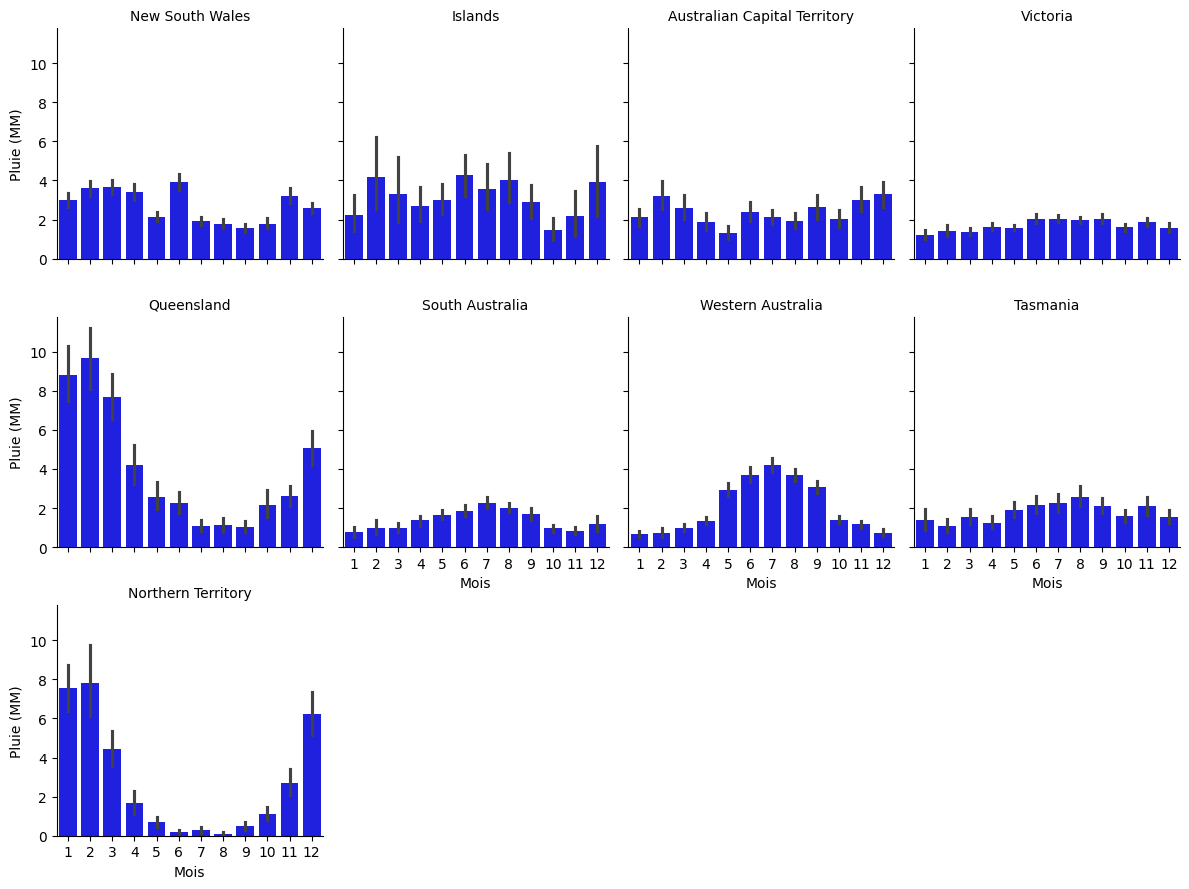

In [ ]:
# Pluie mensuelle par territoire
g = sns.FacetGrid(df, col="Territory", col_wrap=4, height=3, sharex=True, sharey=True)
g.map_dataframe(sns.barplot, x="Month", y="Rainfall", color="blue")


g.set_axis_labels("Mois", "Pluie (MM)")
g.set_titles(col_template="{col_name}")  
plt.show()

## Analyse des doublons
Q°1 : Y a -t-il des lignes exactement identiques pour des stations différentes? 

Q°2 En regardant les données du BOM, on constate que certaines stations (ex Perth) sont en réalités des observations réalisés sur des sites différents. 
Dans ce cas Sunshine et Evaporation viennent de Perth Airport une autre station du jeu de données.
Nous allons vérifier pour chaque station, si pour une colonne donnée l exhaustivité de ses relevés journaliers provient d'une autre station.

Conclusion Q1 : Il y a un doublons le 17/05/2013 : aucune donnée n'a été remontée ni sur Newcastle, ni sur Mount Gini

Conclusion Q2 : Le site du BOM nous confirme que les stations identifées comme copieuses le sont bien (ex: Watsonia : http://www.bom.gov.au/climate/dwo/IDCJDW3079.latest.shtml)
Nous remarquons que les mesures les plus copiées sont Evaporation et Sunshine.
A noter, bien que RainToday et RainTomorrow soient dupliquées entre (Perth<=>Perth Airport et Canberra <=> Tuggeranong), les stations ont bien des mesures de Rainfall différentes

Pour info : confirmer par les relevés 2024 : il y a encore plus de NaN sur ces features, car certaines stations qui historiquement faisaient ces relevés ont arrêtés de les faire. 

In [80]:
#Analyse des doublons : Q°1
print("Il y a ",df.duplicated().sum()," doublons de relevés journaliers par station")

print("Il y a",df.drop(columns='Location').duplicated().sum()," pas de doublons de relevés journalier entre station")
df[df.drop(columns='Location').duplicated(keep=False)]


Il y a  0  doublons de relevés journaliers par station
Il y a 0  pas de doublons de relevés journalier entre station


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,jour,MM,AAAA,District_Rainfall,Territory,Lat,Lon


In [81]:
#Analyse des doublons Q°2
import pandas as pd
from itertools import combinations

def detect_copies(df, variables, threshold=0.95):
    # 1) Pivot tables par variable
    pivots = {
        var: df.pivot(index='Date', columns='Location', values=var)
        for var in variables
    }
    stations = df['Location'].unique()
    results = []

    # 2) Calcul des taux de doublons pour chaque pair
    for var, pv in pivots.items():
        for s1, s2 in combinations(stations, 2):
            ser1, ser2 = pv[s1], pv[s2]
            mask = ser1.notna() & ser2.notna()
            if mask.sum() == 0:
                continue
            rate = (ser1[mask] == ser2[mask]).sum() / mask.sum()
            if rate >= threshold:
                results.append({
                    'variable': var,
                    'station1': s1,
                    'station2': s2,
                    'rate': round(rate, 2)
                })

    df_res = pd.DataFrame(results)
    # 3) Résumé : stations impliquées par variable
    summary = {
        var: sorted(set(
            df_res[df_res['variable']==var]['station1']
            .tolist() +
            df_res[df_res['variable']==var]['station2'].tolist()
        ))
        for var in variables if var in df_res['variable'].values
    }
    return df_res, summary

# Exemple d’utilisation
variables = df.columns[1:]
df_results, copie_summary = detect_copies(df, variables, threshold=0.95)

# Affichage synthétique
print("Stations ayant copié ≥95% des relevés :")
for var, stations in copie_summary.items():
    print(f" - {var} : {stations}")


Stations ayant copié ≥95% des relevés :
 - Evaporation : ['Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Perth', 'PerthAirport', 'Portland', 'Sydney', 'SydneyAirport', 'Watsonia']
 - Sunshine : ['Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'PearceRAAF', 'Perth', 'PerthAirport', 'Portland', 'Sydney', 'SydneyAirport', 'Watsonia']
 - Cloud9am : ['MelbourneAirport', 'Perth', 'PerthAirport', 'Watsonia']
 - Cloud3pm : ['MelbourneAirport', 'Perth', 'PerthAirport', 'Watsonia']
 - RainToday : ['Canberra', 'Perth', 'PerthAirport', 'Tuggeranong']
 - RainTomorrow : ['Canberra', 'Perth', 'PerthAirport', 'Tuggeranong']
 - jour : ['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'Norfolk

## Analyse des variables

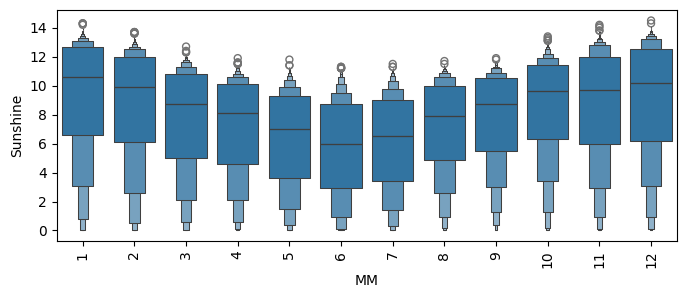

In [82]:
# Rappel de corrélation de Sunshine à mois avant de le supprimer
plt.figure(figsize=(8, 3))  
sns.boxenplot(x="MM", y="Sunshine", data = df)
plt.xticks(rotation = 90);

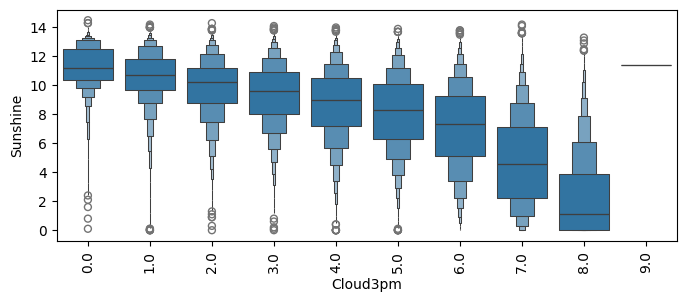

In [83]:
plt.figure(figsize=(8, 3))  
sns.boxenplot(x="Cloud3pm", y="Sunshine", data = df)
plt.xticks(rotation = 90);

In [84]:
#Suppression de Sunshine et Evaporation 
# Pour rappel : Evaporation corrélée à Temp, Sunshine à Cloud et MM
df = df.drop(["Sunshine","Evaporation"], axis = 1)

In [85]:
def analyse_variable (df, variable_cible, liste_variable_quantitative, liste_variable_categorielle):
    import matplotlib.pyplot as plt
    import seaborn as sns

    ## VARIABLE QUANTITATIVE
    
    # Tableau avec stats .describe() et le nb de valeurs uniques (y compris NaN)
    desc_stats = df[liste_variable_quantitative].describe()
    nunique_stats = df[liste_variable_quantitative].nunique() #Aide à identifier si variable est continue ou discrète
    desc_stats.loc['nunique'] = nunique_stats #Ajout de nunique en dernière ligne du dataframe de stats
    display(desc_stats)
    
    for variable in liste_variable_quantitative:

        fig, axes = plt.subplots(1, 2, figsize=(12, 2))
        # Graph 1 : Distribution via Boxplot -> Voir les valeurs extremes/aberrantes
        sns.boxplot(x=df[variable], ax=axes[0])
        axes[0].set_title((('Boxplot de {0}').format(variable)), fontsize=14)

        # Graph 2 : Displot  avec KDE et Histogramme -> pour voir si loi normale (ou bimodale : 2 pics, ou loi uniforme (même kde sur tous les intervalles))
        sns.kdeplot(data=df, x=variable, hue=variable_cible, ax=axes[1])  # KDE (avec la variable de couleur 'RainTomorrow')
        sns.histplot(data=df, x=variable, stat="density", color="gray", ax=axes[1]) 
        axes[1].set_title((('Displot densité de {0}').format(variable)), fontsize=14)

        plt.tight_layout()# Ajuster l'espacement entre les sous-graphiques
        plt.show();
 
    ## VARIABLE CATEGORIELLE
    
    for variable in liste_variable_categorielle:
        print("\n",variable)

        if df[variable].nunique(dropna=True) == 2 : ## Variable catégorielle binaire (indicatrice qd var quantitative?)
            #Répartition variable
            repartition_nb = df[variable].value_counts(normalize=False, dropna=True)
            repartition_propotion = df[variable].value_counts(normalize=True, dropna=True)

            #Tableau de contingence avec la variable cible
            crosstab = pd.crosstab(df[variable],df[variable_cible],normalize="index")

            # Préparer le DataFrame avec les résultats
            result_df = pd.DataFrame({
                'Modalité': repartition_nb.index,  
                'Value Counts': repartition_nb.values,  
                'Proportion': repartition_propotion.values  
            })
            # Ajouter les modalités de la variable cible dans le tableau
            for col in crosstab.columns:
                result_df[col] = crosstab[col].values
            
            result_df.set_index('Modalité', inplace=True)
            print("Tableau de contingence \n")
            display(result_df)
        
        elif pd.api.types.is_numeric_dtype(df[variable]): #Variable catégorielle numérique : Analyser si elles sont ordinales ou cardinale
            #Répartition variable
            print(variable, "min :",df[variable].min()," et max :",df[variable].max())

            #5 premières modalités en %
            display(df[variable].value_counts(normalize = True).head(5))
        
        elif pd.api.types.is_datetime64_any_dtype(df[variable]): #Date
            #Répartition variable
            print("min",df[variable].min())
            print("max",df[variable].max())
            
        ## Variable catégorielle textuelle -> mode
        else :
            print(variable," : ",df[variable].nunique()," valeurs et pour mode", df[variable].mode()[0])
            print(variable," : ",set(df[variable].unique()))

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,MM,AAAA,Lat,Lon
count,143975.000000,144199.000000,142199.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,143693.000000,141851.00000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,16.990631,21.68339,6.399615,2012.769751,-32.863102,141.960395
std,6.398495,7.119049,8.478060,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,6.488753,6.93665,3.427262,2.537684,6.033970,12.034467
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,-7.200000,-5.40000,1.000000,2007.000000,-42.882509,115.100477
25%,7.600000,17.900000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,12.300000,16.60000,3.000000,2011.000000,-36.759018,138.599931
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,16.700000,21.10000,6.000000,2013.000000,-34.026335,145.304505
75%,16.900000,28.200000,0.800000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,21.600000,26.40000,9.000000,2015.000000,-31.673960,150.694171
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,40.200000,46.70000,12.000000,2017.000000,-12.460440,167.948314
nunique,389.000000,505.000000,681.000000,67.000000,43.000000,44.000000,101.000000,101.000000,546.00000,549.000000,441.000000,502.00000,12.000000,11.000000,49.000000,49.000000


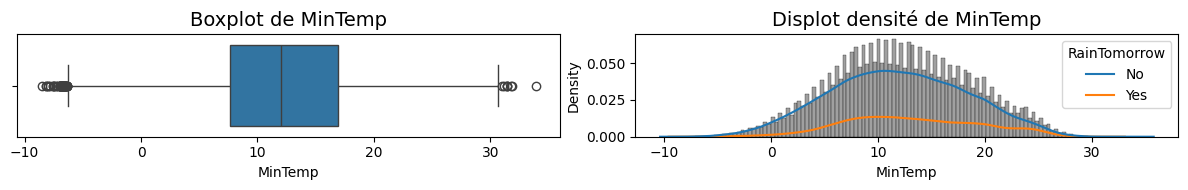

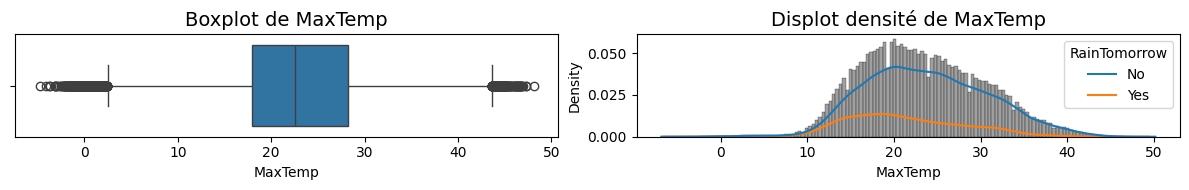

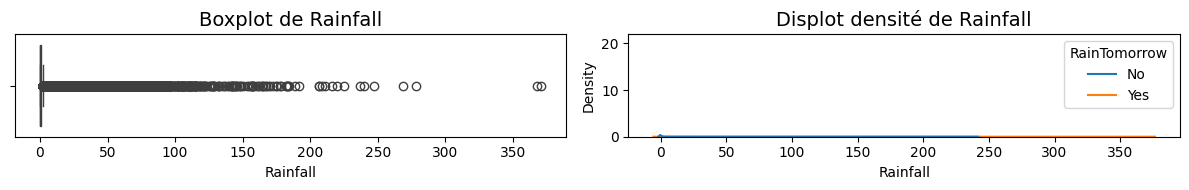

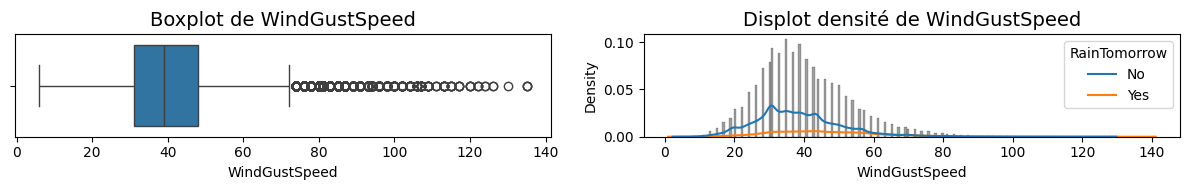

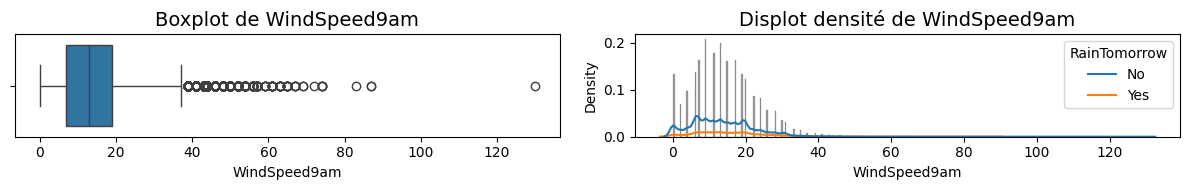

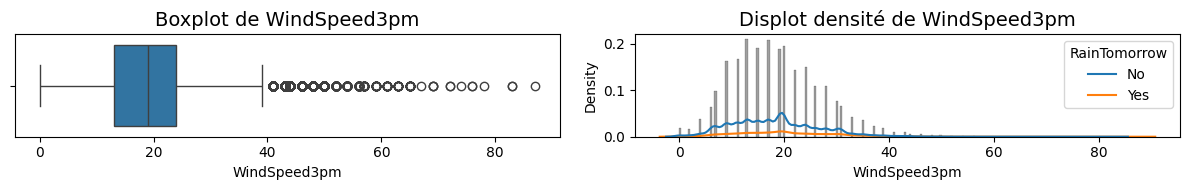

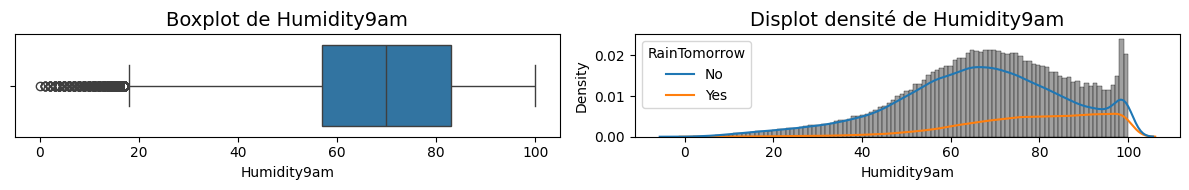

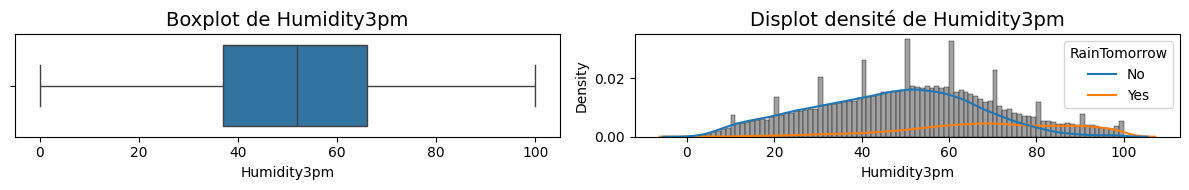

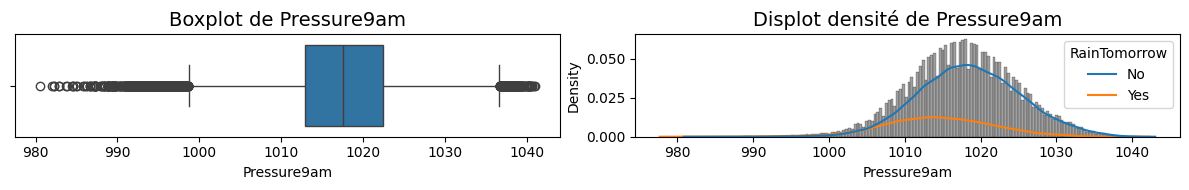

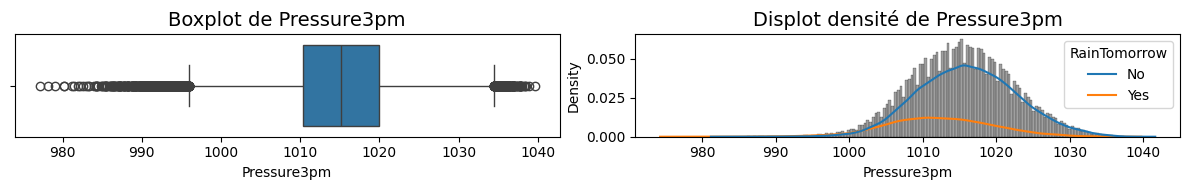

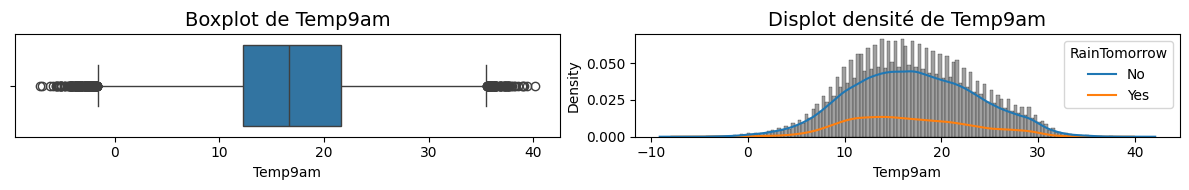

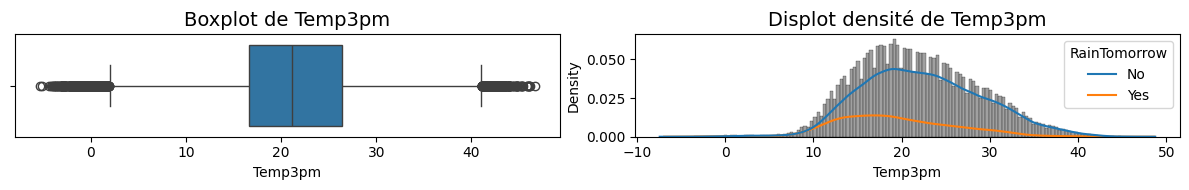

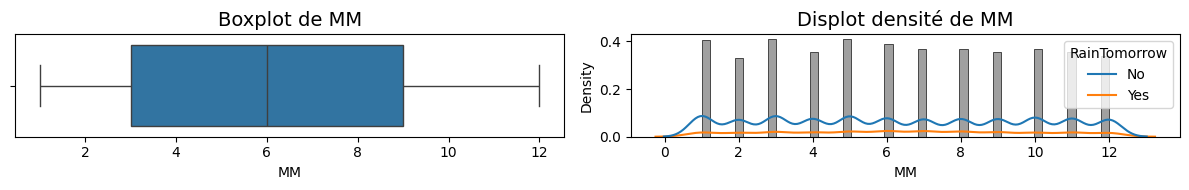

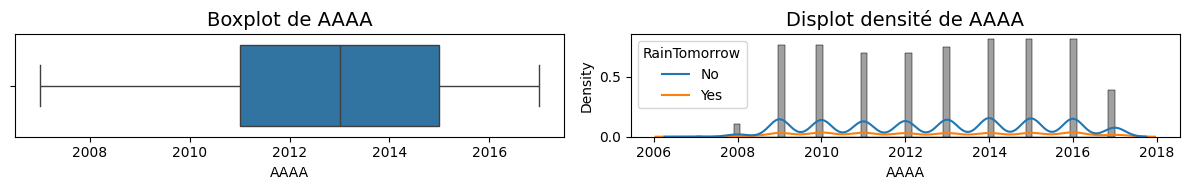

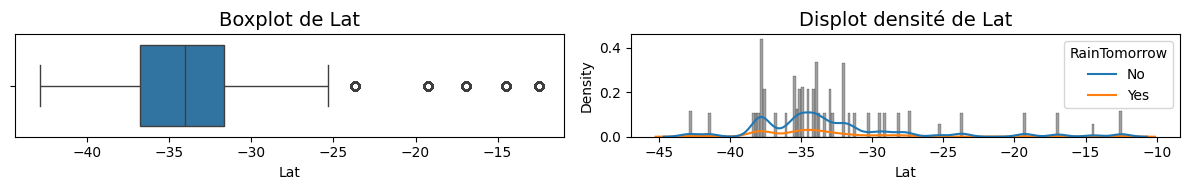

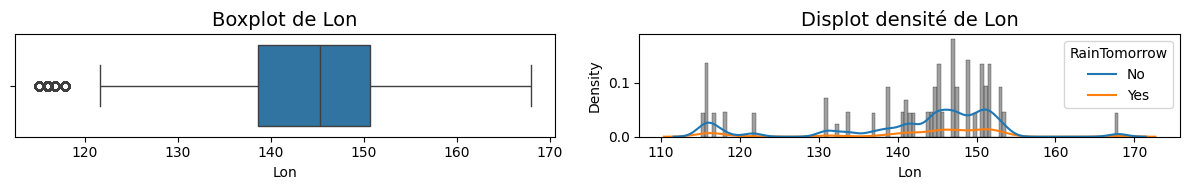


 Location
Location  :  49  valeurs et pour mode Canberra
Location  :  {'Albany', 'Cairns', 'Walpole', 'Uluru', 'Sale', 'MountGambier', 'Katherine', 'Cobar', 'MountGinini', 'Brisbane', 'Mildura', 'GoldCoast', 'Bendigo', 'Sydney', 'Canberra', 'NorahHead', 'Wollongong', 'Richmond', 'BadgerysCreek', 'SydneyAirport', 'Woomera', 'CoffsHarbour', 'NorfolkIsland', 'Adelaide', 'Watsonia', 'AliceSprings', 'MelbourneAirport', 'Nuriootpa', 'Darwin', 'Albury', 'Townsville', 'Ballarat', 'Dartmoor', 'Hobart', 'Penrith', 'Newcastle', 'WaggaWagga', 'Portland', 'Witchcliffe', 'Perth', 'Williamtown', 'Melbourne', 'PerthAirport', 'Moree', 'Nhil', 'SalmonGums', 'Tuggeranong', 'PearceRAAF', 'Launceston'}

 WindGustDir
WindGustDir  :  16  valeurs et pour mode W
WindGustDir  :  {'SE', 'NW', 'W', 'SSE', 'NNW', 'WNW', 'N', 'SSW', 'ESE', 'ENE', 'WSW', 'SW', 'E', nan, 'NNE', 'NE', 'S'}

 WindDir9am
WindDir9am  :  16  valeurs et pour mode N
WindDir9am  :  {'SE', 'NW', 'W', 'SSE', 'NNW', 'N', 'SSW', 'WNW', 'ESE', '

Cloud9am
7.0    0.222971
1.0    0.175133
8.0    0.164080
0.0    0.096481
6.0    0.091223
Name: proportion, dtype: float64


 Cloud3pm
Cloud3pm min : 0.0  et max : 9.0


Cloud3pm
7.0    0.211714
1.0    0.173933
8.0    0.147035
6.0    0.104272
2.0    0.083924
Name: proportion, dtype: float64


 RainToday
Tableau de contingence 



,Value Counts,Proportion,No,Yes
Modalité,,,,
No,110319,0.775807,0.848132,0.151868
Yes,31880,0.224193,0.535940,0.464060



 RainTomorrow
Tableau de contingence 



,Value Counts,Proportion,No,Yes
Modalité,,,,
No,110316,0.775819,1.0,0.0
Yes,31877,0.224181,0.0,1.0



 jour
jour min : 0  et max : 6


jour
3    0.143160
2    0.142995
1    0.142981
4    0.142857
6    0.142850
Name: proportion, dtype: float64


 District_Rainfall
District_Rainfall  :  29  valeurs et pour mode 9
District_Rainfall  :  {9, 12, 14, 15, 16, 23, 26, 31, 32, 40, 48, 53, 59, 61, 66, 67, 68, 70, '999', 72, 76, 78, 81, 85, 86, 89, 90, 91, 94}

 Territory
Territory  :  9  valeurs et pour mode New South Wales
Territory  :  {'Queensland', 'South Australia', 'Western Australia', 'Tasmania', 'Victoria', 'New South Wales', 'Australian Capital Territory', 'Northern Territory', 'Islands'}


In [ ]:
#Lister les variables quantitatives et catégorielles (sauf les dates).
col_var_num = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm','Month', 'Year','Latitude', 'Longitude']
col_var_cat = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow','jour', 'District_Rainfall', 'Territory']

            
analyse_variable(df, "RainTomorrow", col_var_num, col_var_cat)

## Correlation à variable cible

### Direction du vent 
#### A décliner par mois? ou par territoire?

In [87]:
#Correlation % d'observation selon direction du vent selon modalité var cible
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Liste ordonnée des 16 directions du vent (selon les points cardinaux et intermédiaires)
WIND_DIRS = ['E', 'ENE', 'NE', 'NNE', 'N', 'NNW', 'NW', 'WNW',
             'W', 'WSW', 'SW', 'SSW', 'S', 'SSE', 'SE', 'ESE']

def create_rain_wind_traces(df, rain_col, wind_col):
    """
    Crée deux courbes polaires représentant la part (%) d'observations avec et sans pluie
    selon les directions du vent.

    Args:
        df : DataFrame météo contenant les colonnes de pluie et de direction du vent
        rain_col : nom de la colonne indiquant la pluie (RainToday ou RainTomorrow)
        wind_col : nom de la colonne indiquant la direction du vent (WindDir9am ou WindDir3pm)

    Returns:
        (trace_yes, trace_no) : deux objets Scatterpolar (Rain = Yes, Rain = No)
    """
    # Comptage des occurrences par direction pour chaque modalité de pluie
    count_yes = df[df[rain_col] == "Yes"].groupby(wind_col).size().reindex(WIND_DIRS, fill_value=0)
    count_no  = df[df[rain_col] == "No"].groupby(wind_col).size().reindex(WIND_DIRS, fill_value=0)

    # Conversion en pourcentages
    percent_yes = (count_yes / count_yes.sum()) * 100
    percent_no  = (count_no  / count_no.sum()) * 100

    # Création des deux traces polaires
    trace_yes = go.Scatterpolar(r=percent_yes, theta=WIND_DIRS, name='Rain = Yes', fill='toself', marker_color='green')
    trace_no  = go.Scatterpolar(r=percent_no,  theta=WIND_DIRS, name='Rain = No',  fill='toself', marker_color='blue')

    return trace_yes, trace_no

# Création d'une figure 2x2 avec des sous-graphiques polaires
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "9am (RainToday)", "3pm (RainToday)",
        "9am (RainTomorrow)", "3pm (RainTomorrow)"
    ],
    specs=[[{'type': 'polar'}, {'type': 'polar'}],
           [{'type': 'polar'}, {'type': 'polar'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.12
)

# Définir les combinaisons de variables à tracer
combinations = [
    ("RainToday", "WindDir9am",     1, 1),
    ("RainToday", "WindDir3pm",     1, 2),
    ("RainTomorrow", "WindDir9am",  2, 1),
    ("RainTomorrow", "WindDir3pm",  2, 2)
]

# Générer et ajouter les courbes à chaque sous-graphe
for rain_col, wind_col, row, col in combinations:
    trace_yes, trace_no = create_rain_wind_traces(df, rain_col, wind_col)
    fig.add_trace(trace_yes, row=row, col=col)
    fig.add_trace(trace_no,  row=row, col=col)

# Fonction pour appliquer une échelle radiale uniforme (max = 2/16 directions ≈ 12.5 %)
def set_uniform_radial_axes(fig, max_val=12.5):
    """
    Applique une échelle radiale uniforme (0 à 12.5%) à chaque sous-graphique polar.

    Args:
        fig : objet figure Plotly
        max_val : valeur max pour l'axe radial (%)
    """
    tickvals = [0, max_val/2, max_val]
    ticktext = ["0%", "1/16", "2/16"]

    # Compatibilité ancienne version (polar sans suffixe)
    for i in range(1, 5):
        key = 'polar' if i == 1 else f'polar{i}'
        if key in fig.layout:
            fig.layout[key].radialaxis = dict(
                visible=True,
                range=[0, max_val],
                tickvals=tickvals,
                ticktext=ticktext
            )

# Appliquer l'échelle radiale
set_uniform_radial_axes(fig)

# Mise en page générale de la figure
fig.update_layout(
    title="Distribution du vent selon la pluie (en % d'observations)",
    title_font_size=24,
    showlegend=True,
    paper_bgcolor='white',
    height=900,
    width=800,
    margin=dict(t=80, b=40, l=50, r=50),
)

# Affichage final
fig.show()



Tendance peut venir de climat plus présents que d'autres (+ de Location, + de relevés/Location ) : A faire par location? ou territoire (9)? ou district rainfall (28)?

### Correlation Cloud et Var Cible. 
Ajoutant le mois? la station? pk pas ds analyse au dessus?

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\2128341715.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\2128341715.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\2128341715.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\2128341715.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



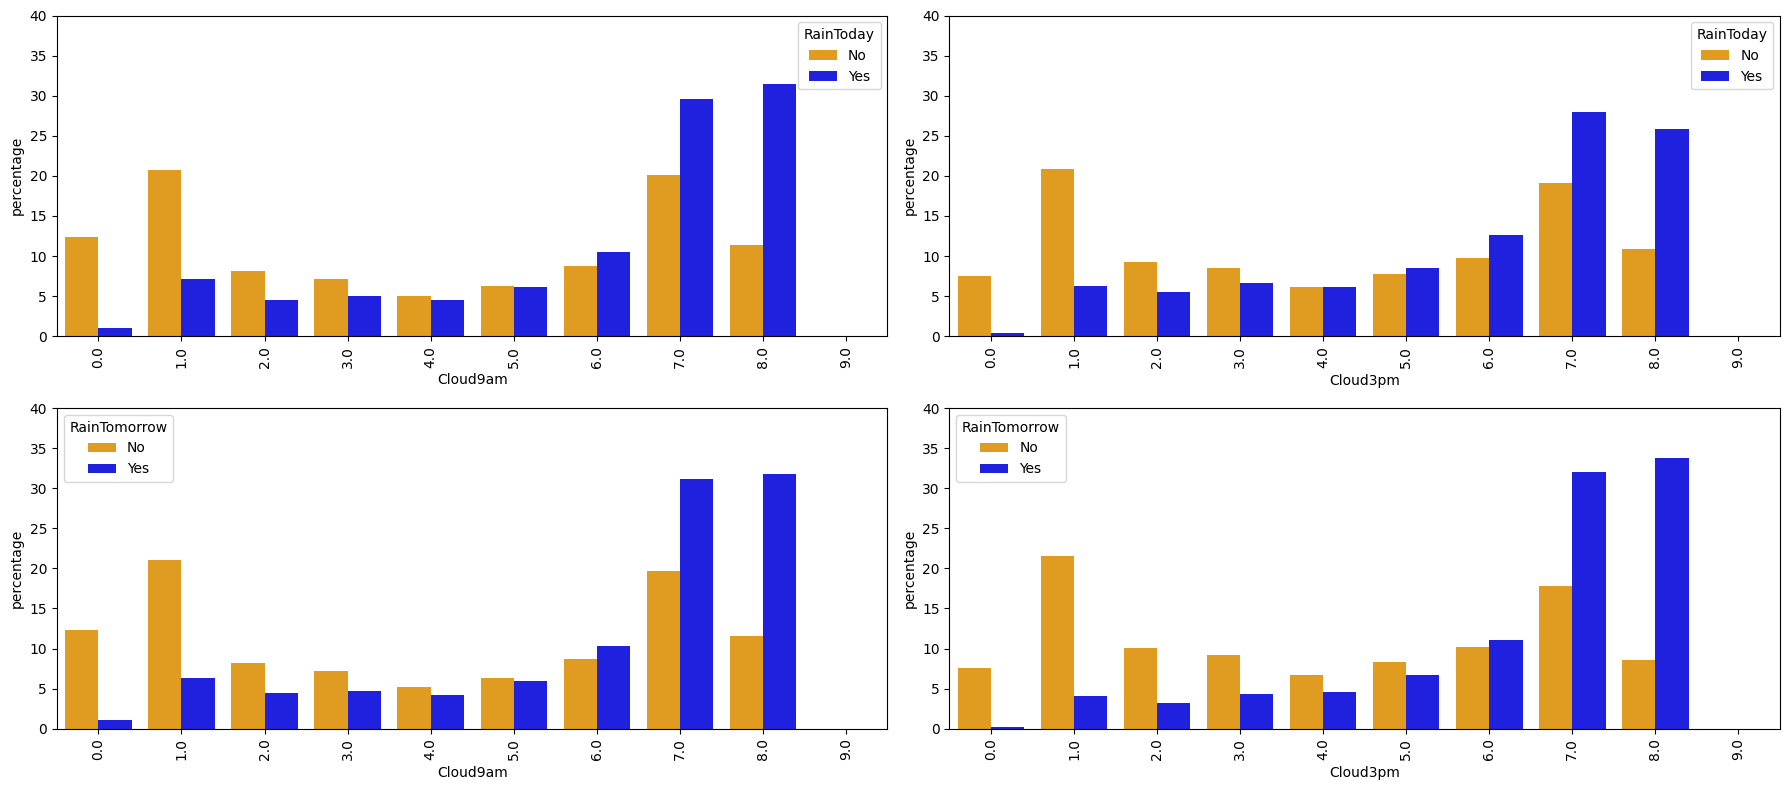

In [88]:
#Y a til une correlation entre nuage et var cible?

# Fonction pour créer un barplot
def create_barplot(df, group_by, column, ax, hue=None, order=None):
    graph = (df.groupby([group_by])[column]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(column))
    
    # Définir la palette de couleurs pour hue binaire
    custom_palette = {'Yes': 'blue', 'No': 'orange'} if hue else None

    sns.barplot(x=column, y='percentage', hue=hue, data=graph, ax=ax, palette=custom_palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim(0, 40)  # Fixer l'échelle de l'axe y de 0 à 40%


f, axes = plt.subplots(2, 2, figsize=(18, 8))

create_barplot(df, 'RainToday', 'Cloud9am', axes[0, 0], hue='RainToday')
create_barplot(df, 'RainToday', 'Cloud3pm', axes[0, 1], hue='RainToday')
create_barplot(df, 'RainTomorrow', 'Cloud9am', axes[1, 0], hue='RainTomorrow')
create_barplot(df, 'RainTomorrow', 'Cloud3pm', axes[1, 1], hue='RainTomorrow')

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show();


In [89]:
#Suppression des NaN sur variables cibles et Label encoder de cette variable indicatrice en variable binaire
df = df.dropna(subset=["RainTomorrow"], axis=0, how="any")

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df["RainTomorrow"] = encoder.fit_transform(df["RainTomorrow"])  #N=0, Y=1

,Territory,District_Rainfall,Location,Lat,Lon,target_mean,nb_lignes,Loc_concat
0,Australian Capital Territory,70,Canberra,-35.297591,149.101268,0.184026,3418,Australian Capital Territory-70-Canberra


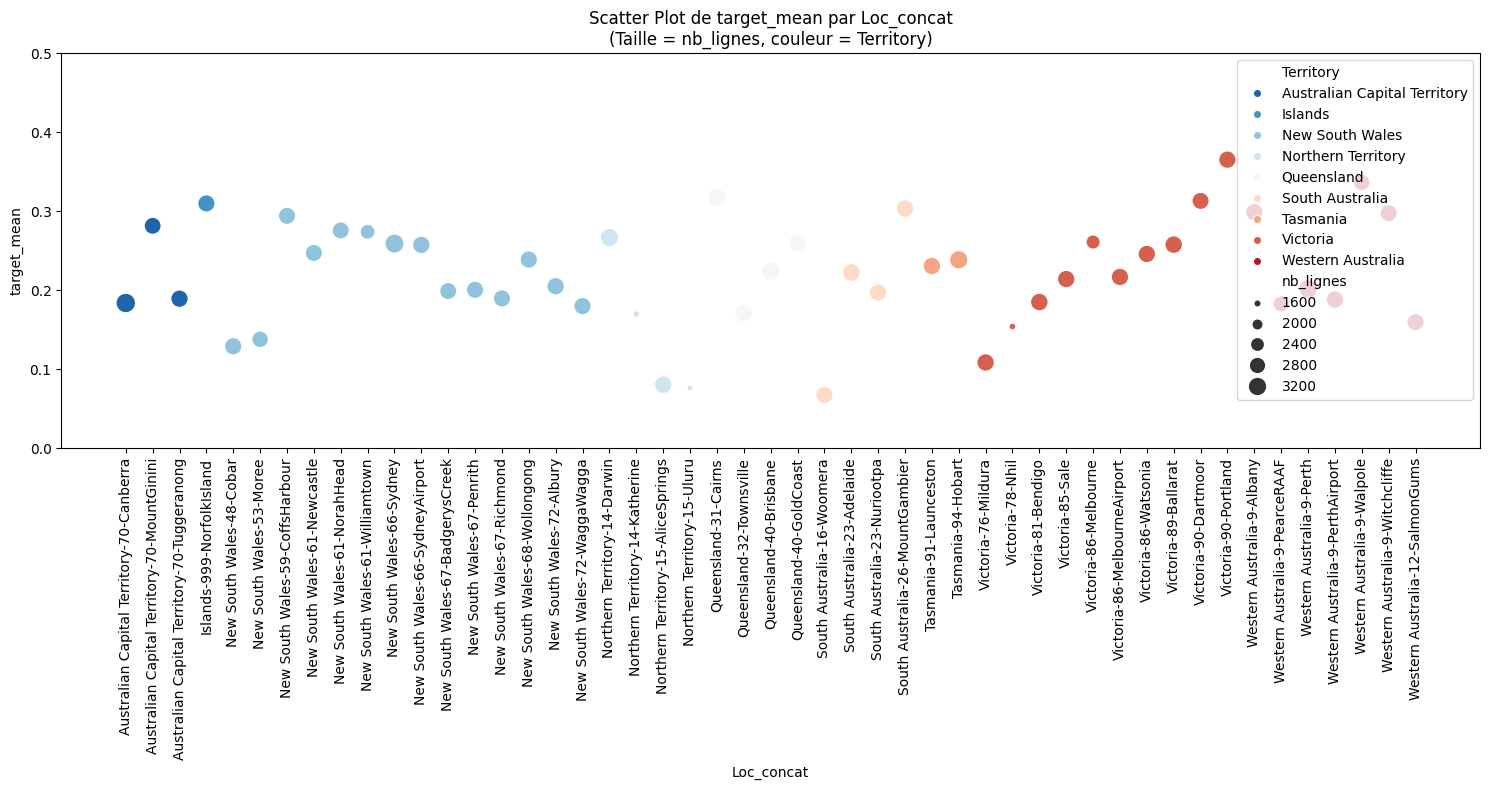

In [ ]:
# Analyse RainTomorrow par zone
df_target_location = df.groupby(["Territory", "District_Rainfall", "Location", "Latitude", "Longitude"]).agg(
    target_mean=('RainTomorrow', 'mean'),nb_lignes=('RainTomorrow', 'count')).reset_index()

df_target_location["Loc_concat"] = (df_target_location["Territory"].astype(str)+ "-" + 
                                    df_target_location["District_Rainfall"].astype(str)+ "-" + df_target_location["Location"].astype(str))
display(df_target_location.head(1))

#Location : taille = nb observations, y= target_mean, hue=Territory
plt.figure(figsize=(15, 8))
scatter = sns.scatterplot(
    data=df_target_location,
    x="Loc_concat",
    y="target_mean",
    hue="Territory",       # Couleur par Territory
    size="nb_lignes",      # Taille des bulles proportionnelle au nombre d'obeservations dans le df'
    sizes=(20, 200),       # Ajustement de l'échelle de taille
    palette="RdBu_r"      
)

scatter.set_ylim(0, 0.5)
plt.title("Scatter Plot de target_mean par Loc_concat\n(Taille = nb_lignes, couleur = Territory)")
plt.xlabel("Loc_concat")
plt.ylabel("target_mean")
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

## NaN : suppression d'observations



In [91]:
display(pd.DataFrame(df.isna().sum(), columns=["Nombre de NA"]))

,Nombre de NA
Date,0
Location,0
MinTemp,637
MaxTemp,322
Rainfall,1406
WindGustDir,9330
WindGustSpeed,9270
WindDir9am,10013
WindDir3pm,3778
WindSpeed9am,1348


### Corrélation dans l'absence de manquants
https://datascientest.com/missingno-tout-savoir
https://datascientest.com/dendrogramme

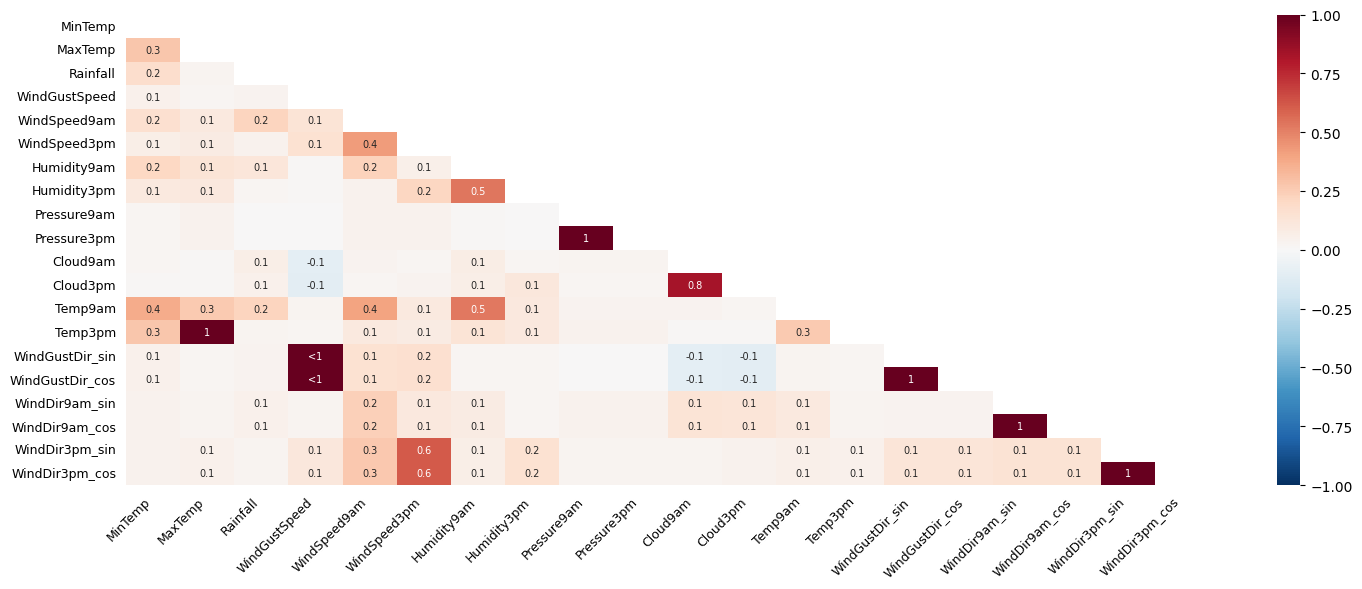

In [121]:
# Corrélation des manquants
# Créer la figure et l'axes désirés
fig, ax = plt.subplots(figsize=(15, 6))

# Tracer le heatmap de missingno sur cet axes
msno.heatmap(df, vmin=-1, vmax=1, cmap="RdBu_r", ax=ax, fontsize=9)

# Réduction de la taille des labels des axes
ax.tick_params(axis='x', labelsize=9, rotation=45)  # x en vertical
ax.tick_params(axis='y', labelsize=9)
    
# Afficher
plt.tight_layout()
plt.show()

#Lecture
#Une valeur proche de -1 signifie que si une variable apparaît, il est très probable que l’autre variable soit manquante. -> anti-corrélé
#Une valeur proche de 0 signifie qu’il n’y a pas de corrélation particulière sur la présence ou non de valeurs entre deux variables.
#Une valeur proche de 1 signifie que si une variable apparaît, il est très probable que l’autre variable soit présente.

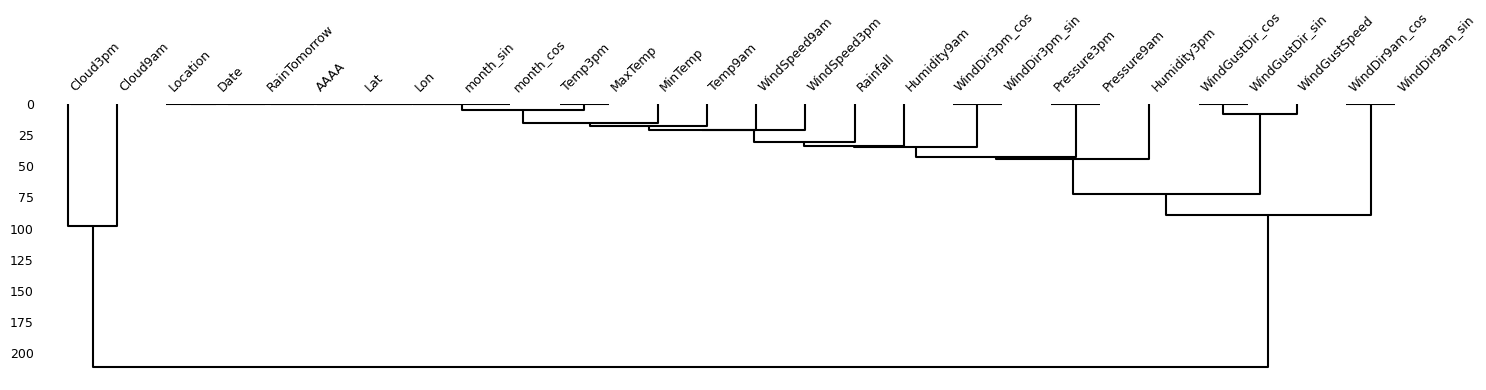

In [127]:
#Dendrogramme (-> diagramme en arborescence) Corrélation des manquants
fig, ax = plt.subplots(figsize=(15, 4))

# Tracer le heatmap de missingno sur cet axes
msno.dendrogram(df, ax=ax)

# Réduction de la taille des labels des axes
ax.tick_params(axis='x', labelsize=9, rotation=45)  # x en vertical
ax.tick_params(axis='y', labelsize=9)
    
    
# Afficher
plt.tight_layout()
plt.show()


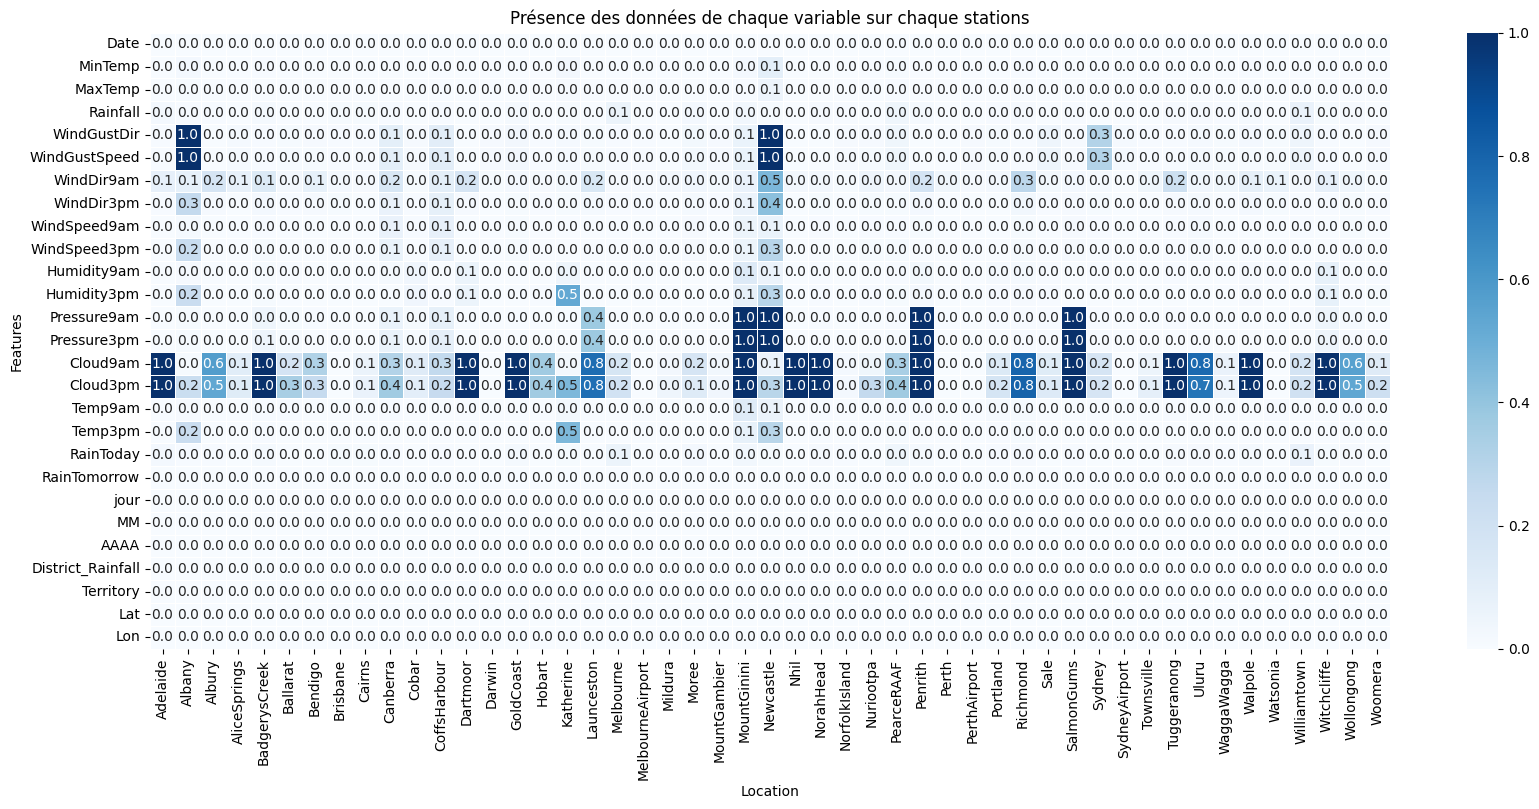

In [93]:
#GRAPH %de NAN par variables et par station
#Dataframe avec Booleen pour NAN sur toutes les colonnes sauf location
df_sans_location= df.drop("Location",axis = 1).iloc[:, :].isna() 
df_col_location =  df.iloc[:, 1:2]
df_NAN_apres_3e_col= df_col_location .join(df_sans_location)

df_NAN_Location = df_NAN_apres_3e_col.groupby("Location").mean()

# Affichage graphe

plt.figure(figsize=(20, 8))
sns.heatmap(df_NAN_Location.T, cmap="Blues", cbar=True, linewidths=0.5, linecolor="white", annot= True, fmt= ".1f")
plt.title("Présence des données de chaque variable sur chaque stations")  #Mettre les lignes du groupeby en y, et en x les colonnes du groupby
plt.xlabel("Location")
plt.ylabel("Features")
plt.show()

On supprimera les 4 stations qui ne remontent ni les pressions : ni la nébulosité ("MountGinini","Penrith","SalmonGums") ou ni les rafales ("Newcastle")
("MountGinini","Penrith","SalmonGums") ne remontente pas non plus les pressions en 2024. (pour info)

Albany et Melbourne ont des manquants sur plusieurs features. Anlaysons d'avantage

-> Commençons par vérifier le taux de NaN par station et par mois : Les premiers mois (1A)/jours(1B)de mises en oeuvres ont peut-être été chaotiques.

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\1873382273.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



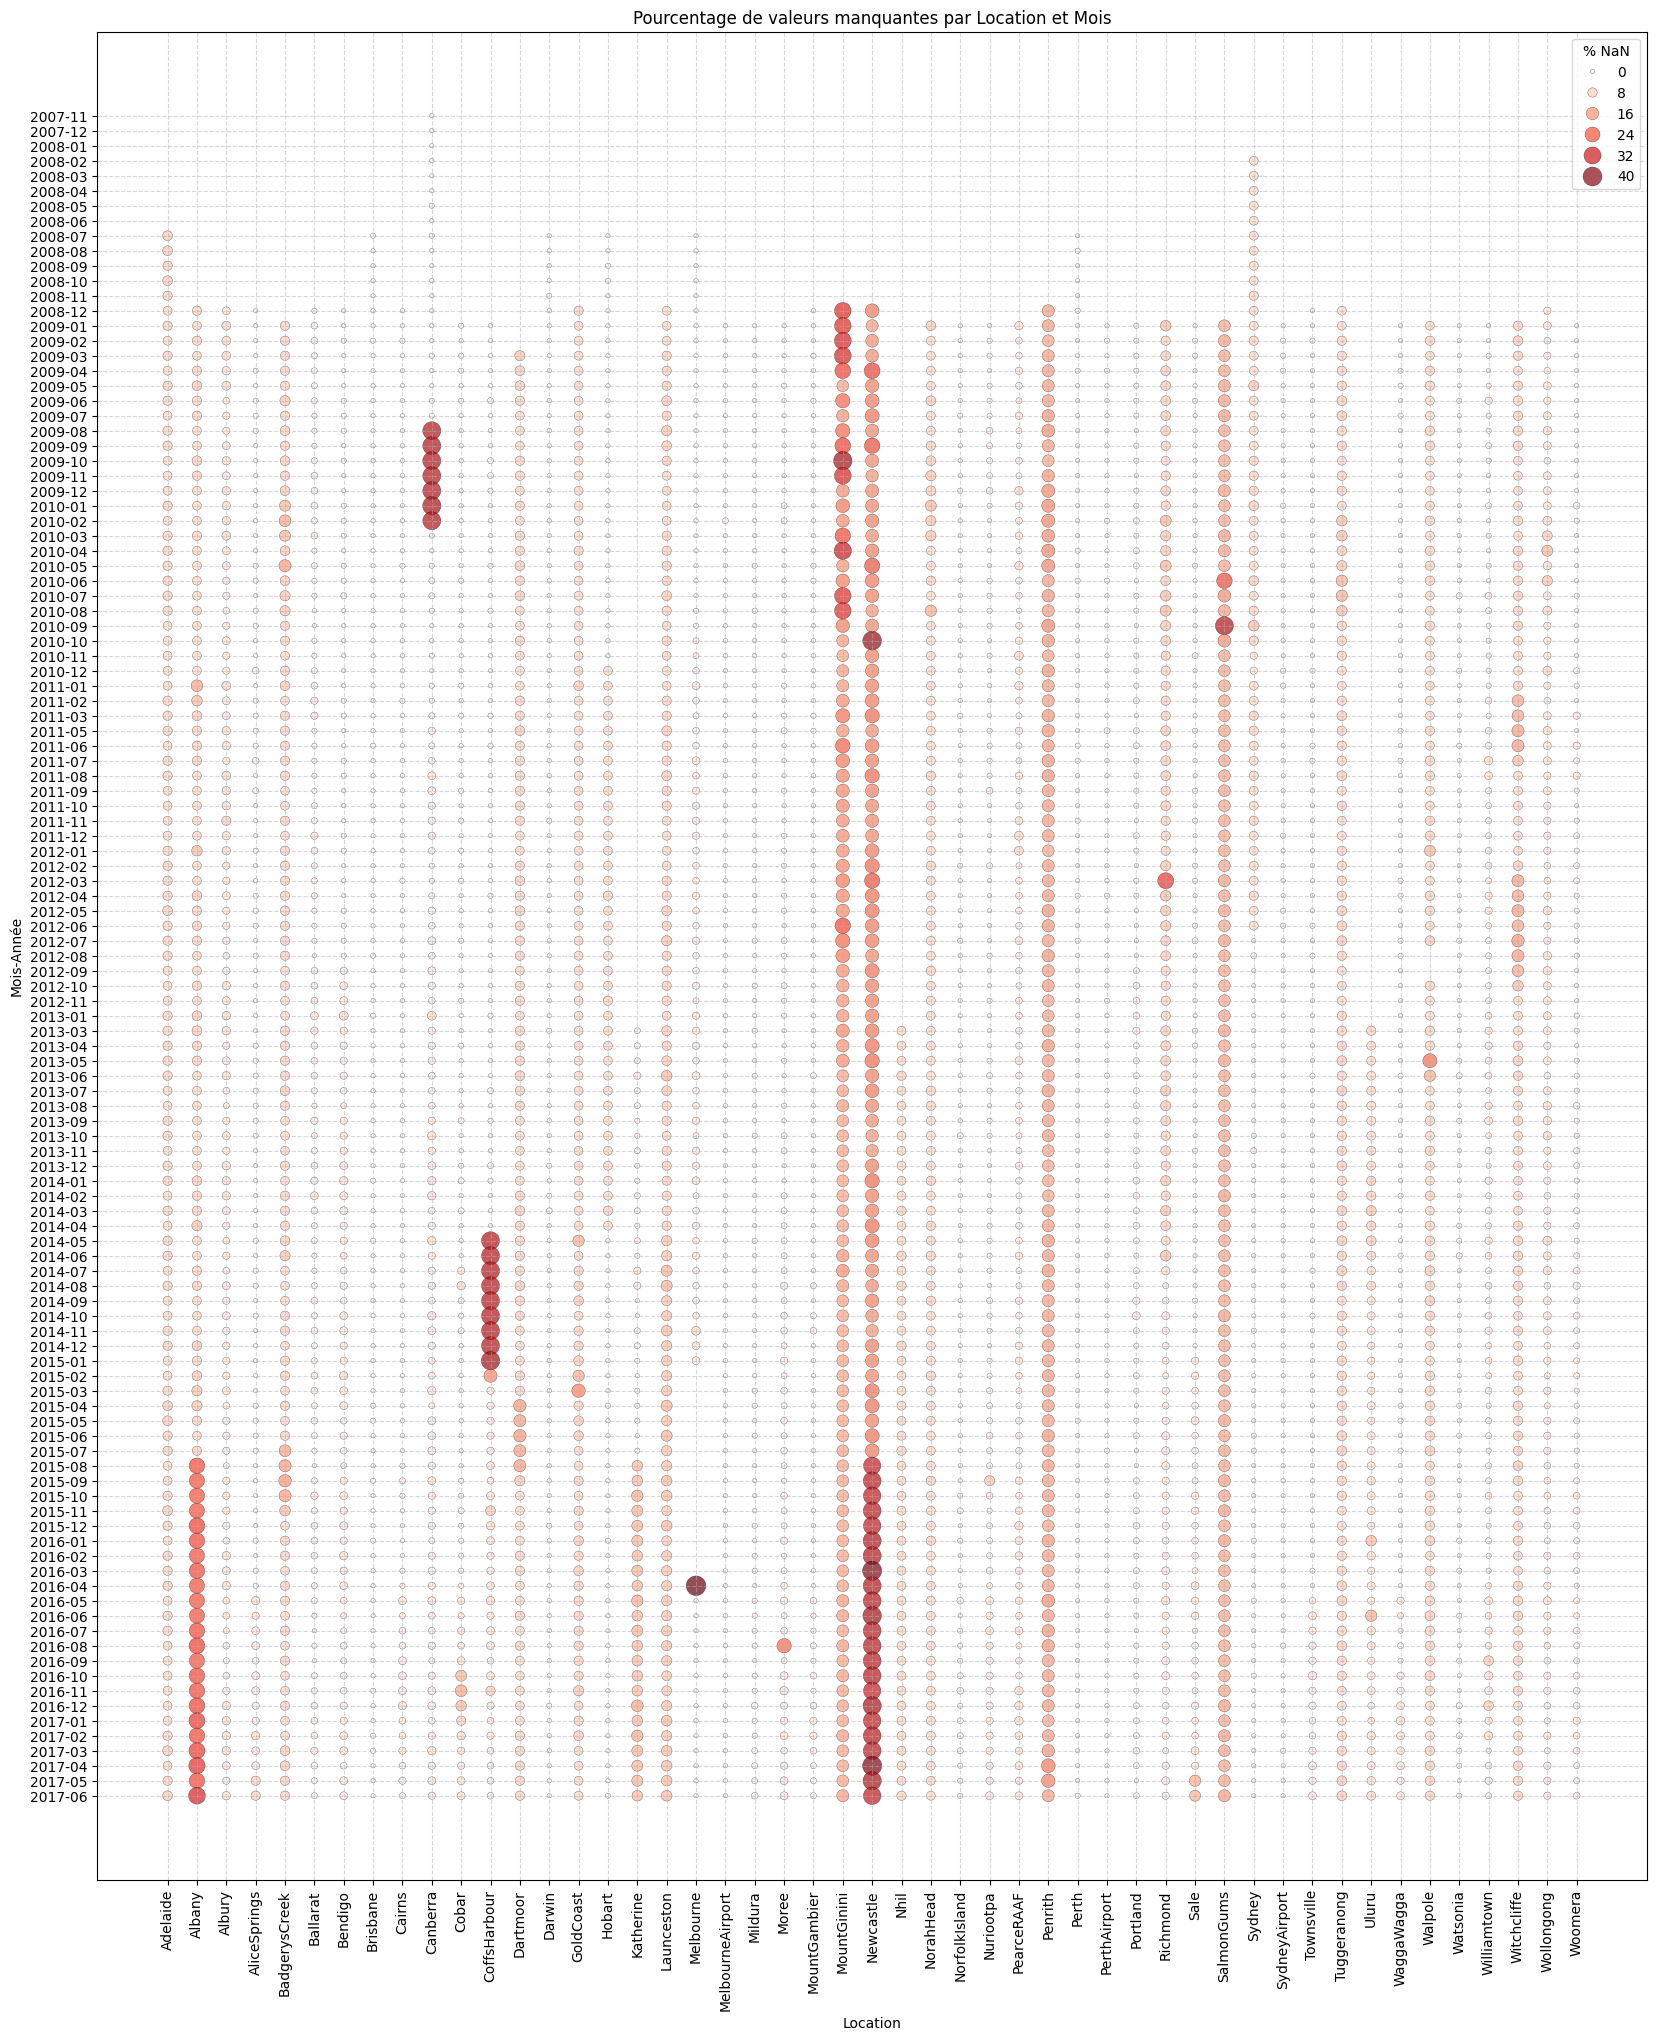

In [ ]:
# 1A Calcul du % de NaN pour chaque groupe (Year, Month, Location)
manque_location = (
    df.groupby(["Year", "Month", "Location"])  # Regrouper par Year, Month et Location
    .apply(lambda x: x.isnull().mean().mean() * 100)  # Moyenne du % de NaN par groupe
    .reset_index(name="NaN_Percentage")  # Convertir en DataFrame
)

# Fusionner Month et Year pour créer l'index "Month-Year"
manque_location["Month-Year"] = manque_location["Year"].astype(str)+ "-" + manque_location["Month"].astype(str).str.zfill(2) 

# Reformater en tableau avec Locations en colonnes et Month-Year en index
manque_location = manque_location.pivot(index="Month-Year", columns="Location", values="NaN_Percentage").round(0)


# Reset index pour utiliser Month-Year coMonthe colonne
df_plot = manque_location.reset_index().melt(id_vars=["Month-Year"], var_name="Location", value_name="NaN_Percentage")

# Création du scatter plot
plt.figure(figsize=(20, 24))
scatter = sns.scatterplot(
    data=df_plot,
    x="Location", y="Month-Year", size="NaN_Percentage", hue="NaN_Percentage",
    palette="Reds", sizes=(10, 200), edgecolor="black", alpha=0.7
)

plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Mois-Année")
plt.title("Pourcentage de valeurs manquantes par Location et Mois")
plt.legend(title="% NaN", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.5);

In [95]:
# 1B Nous allons faire un zoom sur les 15 premiers jours de relevés de chaque station
liste_station = sorted(set(df["Location"]))

nan_counts_dict = {}
for station in liste_station:
    df_station_temp = df[df["Location"] == station]
    df_station_temp = df_station_temp.reset_index()
    
    # Trouver l'indice de la 1e observation
    idx_min_date = df_station_temp["Date"].idxmin()
    premiere_obs=(df_station_temp.iloc[0,1])
    next_15_rows = df_station_temp.iloc[idx_min_date : idx_min_date + 15] #Sélectionner les 15 premières observations d'une station
    
    # Compter les NaN pour chaque ligne
    nan_counts = next_15_rows.isna().sum(axis=1).tolist()
    
    # Ajouter au dictionnaire
    nan_counts_dict[station+str(premiere_obs)] = nan_counts

# Convertir le dictionnaire en DataFrame
nan_counts_df = pd.DataFrame(nan_counts_dict)
display(nan_counts_df)

,Adelaide2008-07-01 00:00:00,Albany2008-12-01 00:00:00,Albury2008-12-01 00:00:00,AliceSprings2008-12-01 00:00:00,BadgerysCreek2009-01-01 00:00:00,Ballarat2008-12-01 00:00:00,Bendigo2008-12-01 00:00:00,Brisbane2008-07-01 00:00:00,Cairns2008-12-01 00:00:00,Canberra2007-11-01 00:00:00,Cobar2009-01-01 00:00:00,CoffsHarbour2009-01-01 00:00:00,Dartmoor2009-03-05 00:00:00,Darwin2008-07-01 00:00:00,GoldCoast2008-12-01 00:00:00,Hobart2008-07-01 00:00:00,Katherine2013-03-01 00:00:00,...,PerthAirport2009-01-01 00:00:00,Portland2009-01-01 00:00:00,Richmond2009-01-01 00:00:00,Sale2009-01-01 00:00:00,SalmonGums2009-01-01 00:00:00,Sydney2008-02-01 00:00:00,SydneyAirport2009-01-01 00:00:00,Townsville2008-12-01 00:00:00,Tuggeranong2008-12-01 00:00:00,Uluru2013-03-01 00:00:00,WaggaWagga2009-01-01 00:00:00,Walpole2009-01-01 00:00:00,Watsonia2009-01-01 00:00:00,Williamtown2009-01-01 00:00:00,Witchcliffe2009-01-01 00:00:00,Wollongong2008-12-03 00:00:00,Woomera2009-01-01 00:00:00
0,2,2,1,0,7,1,0,0,0,0,0,0,15,0,2,0,0,...,0,1,4,0,4,2,0,0,2,2,0,2,0,0,2,9,2
1,2,2,2,0,2,0,0,0,0,0,0,0,3,0,2,0,0,...,0,0,4,0,4,2,0,0,2,2,0,2,0,0,2,0,1
2,2,2,1,0,2,0,0,0,0,0,6,0,2,0,2,0,0,...,0,0,4,0,4,2,2,0,2,2,0,2,0,0,2,1,0
3,2,2,2,0,2,1,0,0,0,0,0,0,2,0,2,0,0,...,0,0,4,0,4,2,0,0,2,2,0,2,0,0,2,1,0
4,4,2,0,0,2,0,0,0,0,0,0,0,2,0,2,0,1,...,0,0,4,0,4,2,0,0,2,2,0,2,0,0,2,0,0
5,2,2,2,0,2,0,0,0,0,0,0,0,2,0,2,0,4,...,0,3,4,0,4,2,0,0,2,2,0,2,0,0,2,0,0
6,2,2,1,0,2,0,0,0,0,0,0,0,2,0,2,0,0,...,0,0,4,0,4,2,0,0,2,2,0,2,0,0,2,1,0
7,2,2,2,0,2,1,0,0,0,0,0,0,3,0,2,0,0,...,0,0,4,0,4,2,0,0,2,2,0,2,0,0,2,0,0
8,2,2,2,0,2,0,0,0,0,0,0,0,3,0,5,0,0,...,0,0,4,1,4,2,0,0,2,2,0,2,0,0,2,0,0
9,4,2,2,0,2,1,0,0,0,0,0,0,2,0,2,0,0,...,0,1,4,0,4,2,0,0,2,2,0,2,0,0,2,0,0


Les premiers mois de Dartmoor ont été assez chaotiques, nous allons les enlever (1er graph)
Ainsi que les premiers jours Wollongong.

Concernant Albany et Melbourne, il y a eu un problème sur les relevés durant plusieurs mois consécutifs. 
Supprime-ton les stations au risque de créer un désequilibre géographique? 
ou supprime-t-on les mois au risque de créer un désequilibre sur la saisonnalité? 
> Pour Melbourne, nous disposons de Melbourne Airport, il n'y aura donc pas de biais géogrpahique avec une région non représentée si on supprime Melbourne

Pour ALbany, comme il y a déjà des trous de mois dans le dataset, je vais supprimer les mois de mauvaise qualité pour le moment.


In [96]:
#Suppressions des stations avec beaucoup de NAN, ou des mois de relevés avec beaucoup de NaN

# 4 stations qui ne remontent ni les pressions : ni la nébulosité ("MountGinini","Penrith","SalmonGums") ou ni les rafales ("Newcastle")
station_a_supprimer = ["MountGinini","Penrith","SalmonGums", "Newcastle","Melbourne"]
df = df.loc[~df["Location"].isin(station_a_supprimer)] 

# mois où les démarrages des relevés sont de mauvaises qualité (3 premiers mois de Dartmoor, les premiers jours de Wollongong)
to_remove_bad_launch = [
    (1, 2009, "Dartmoor"),
    (2, 2009, "Dartmoor"),
    (3, 2009, "Dartmoor"),
    (12, 2008, "Wollongong")] 
df = df[~df.set_index(["MM", "AAAA", "Location"]).index.isin(to_remove_bad_launch)]

#Période pendant laquelle la qualité des relevés diminuent subitement
remove_periods = [
    # Albany : 2015-08 à 2017-06
    {"start": pd.Timestamp('2015-08-01'), "end": pd.Timestamp('2017-06-30'), "station": "Albany"},
    # Coffs Harbour : 2014-05 à 2015-02
    {"start": pd.Timestamp('2014-05-01'), "end": pd.Timestamp('2015-02-28'), "station": "CoffsHarbour"},
    # Canberra : 08-2009 à 02-2010
    {"start": pd.Timestamp('2009-08-01'), "end": pd.Timestamp('2010-02-28'), "station": "Canberra"}]

# Filtrer et supprimer les lignes dont les dates tombent dans ces périodes
for period in remove_periods:
    mask = (df['Location'] == period['station']) & (df['Date'] >= period['start']) & (df['Date'] <= period['end'])
    df = df[~mask]

df = df.reset_index()
df = df.drop("index", axis = 1)


Analyser Cloud : Ssupprimer des stations?
Les nuages ont une corrélations intéressantes à la variable cible. Il vaudrait mieux les conserver et les compléter.
Pour les stations qui ne font pas cette mesure, on mettra les NaN à 9 qui correspond à l'impossibilité de mesurer la couverture nuageuse

## Est-ce qu'il y a plus de manquants le WE?
Q1° Sur Rainfall (qui sert de calcul à Var cible) : y a-t-il plus de manquants le WE?
Conclusion : Il y a plus de manquants le WE sur Rainfall

Q°2 : Est-ce qu'il ya plus de manquants le WE sur certaines stations?
Conclusion : Il y a plus de manquants le WE sur certaines stations -> Moree, PearceRAAF et WilliamTown

Q°3 Il y a un risque que les Rainfall du Lundi soient constitués des Rainfall de Samedi et Dimanche
Conclusion : Cela saute aux yeaux sur Pearce (moyenne du Lundi fortement supérieure aux autres jours de la semaine),et Williamtown du Samedi au Dimanche, pour les autres c'est plus difficile à dire

### Conclusion sur les NAN en Rainfall : 
Les notes du BOM : From time to time, observations will not be available, for a variety of reasons. Sometimes when the daily maximum and minimum temperatures, rainfall or evaporation are missing, the next value given has been accumulated over several days rather than the normal one day. It is very difficult for an automatic system to detect this reliably, so caution is advised. 

Dans la mesure où, on ne peut établir avec certitude que la valeur qui suit un NaN est une aggrégation du jour et de la(les) jour(s) manquant. Il serait prudent de 
supprimer ces observations manquantes et celle qui les suit imméditatement.
> ou supprimer les stations concernée

In [97]:
#Q°1 : Manquants sur Rainfall le we?
display(df.groupby("jour")["Rainfall"].apply(lambda x: x.isna().sum())) #vérifier si mesure de Rainfall varie selon le jour de la semaine (nb de NaN)
print("On remarque qu'il manque plus de données le WE") #0 = Lundi

jour
0     76
1     76
2    138
3    103
4    114
5    218
6    340
Name: Rainfall, dtype: int64

On remarque qu'il manque plus de données le WE


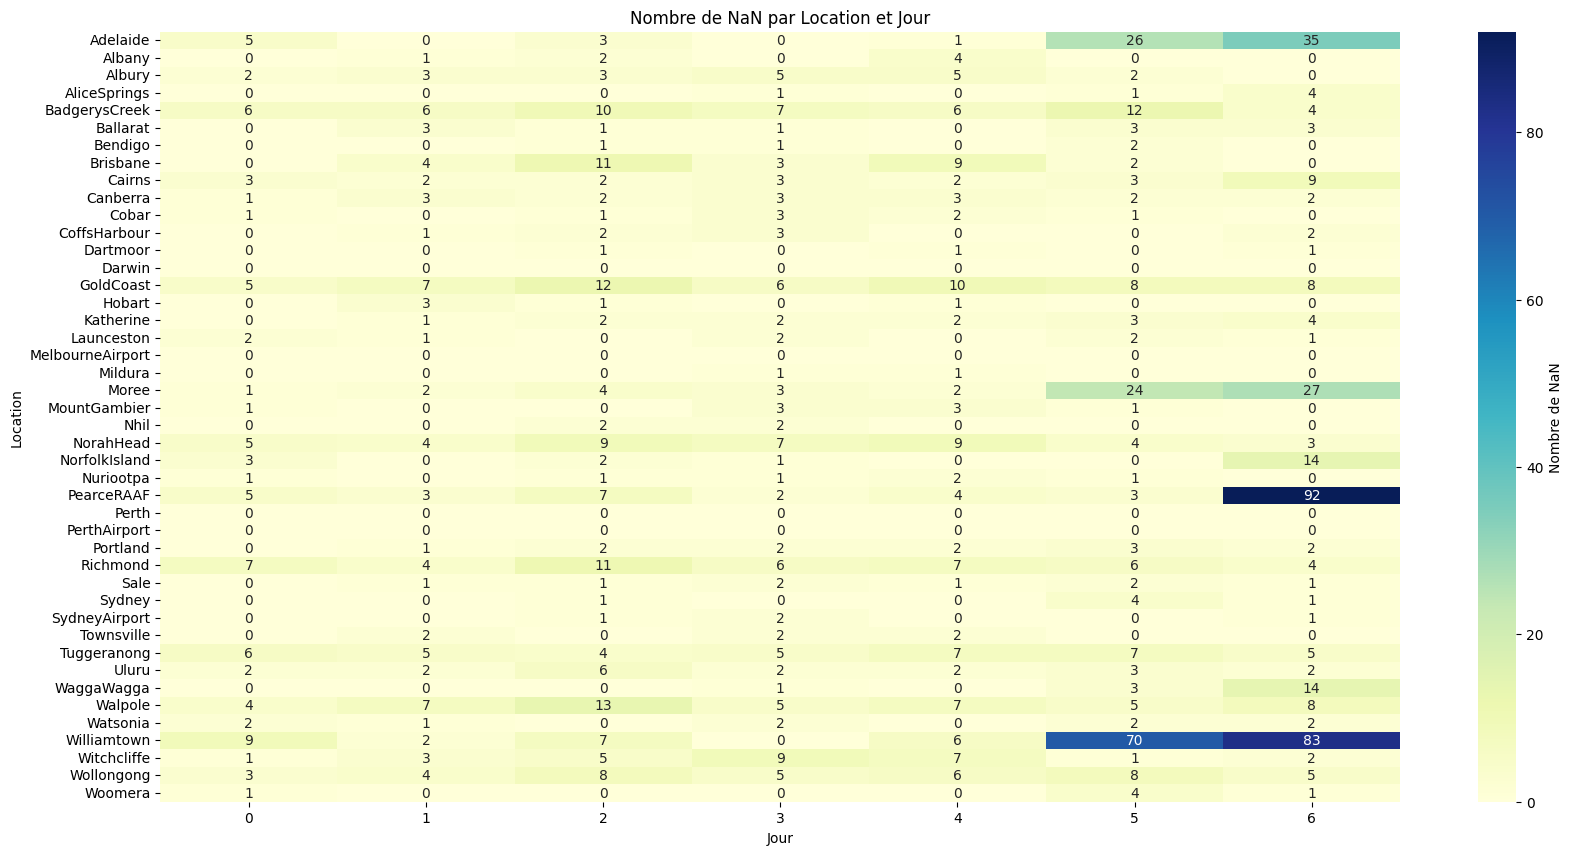

In [98]:
#Q°2 Graphique : Ya-t-il plus de données manquantes le we sur certaines stations?

import matplotlib.pyplot as plt
import seaborn as sns

nan_count = df.groupby(['Location', 'jour'])['Rainfall'].apply(lambda x: x.isna().sum()).unstack()

# Afficher la heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(nan_count, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Nombre de NaN'})
plt.title('Nombre de NaN par Location et Jour')
plt.ylabel('Location')
plt.xlabel('Jour')
plt.show()

In [99]:
#Q°3 Sur les stations les plus concernées par ces NaN en Rainfall le WE, voyons nous un report des QT du WE sur le Lundi?
# Grouper par Location et jour (0 à 6, où 0 = Lundi, 6 = Dimanche) et calculer la moyenne de Rainfall
df_pb_report_rainfall = df[(df["Location"] == "Williamtown") | (df["Location"] == "Melbourne") | (df["Location"] == "PearceRAAF")| (df["Location"] == "Moree")]
rainfall_mean = df_pb_report_rainfall.groupby(["Location", "jour"])['Rainfall'].mean().unstack(fill_value=0).round(2)

# Calculer l'écart entre les précipitations du dimanche (6) et du lundi (0)
rainfall_mean['Ecart_Dim_Lun'] = abs(rainfall_mean[6] - rainfall_mean[0])
rainfall_mean['Ecart_Sam_Dim'] = abs(rainfall_mean[5] - rainfall_mean[6])

# Trier les valeurs en fonction de l'écart (de manière décroissante)
print("Stations avec report")
display(rainfall_mean.head(5))

Stations avec report


jour,0,1,2,3,4,5,6,Ecart_Dim_Lun,Ecart_Sam_Dim
Location,,,,,,,,,
Moree,1.82,1.52,1.54,1.82,1.29,1.85,1.39,0.43,0.46
PearceRAAF,2.96,1.60,1.52,1.68,1.09,0.97,1.28,1.68,0.31
Williamtown,5.31,3.11,3.44,2.21,2.05,2.06,5.33,0.02,3.27


#### Supprimer les NAN Rainfall pour les stations qui en ont bcp

In [100]:
pourcentage_nan = df.groupby("Location")["Rainfall"].apply(lambda x: x.isna().mean() * 100)
pourcentage_nan.sort_values(ascending=False).head(5)

Location
Williamtown    6.933020
PearceRAAF     4.199855
Adelaide       2.265372
Moree          2.207428
GoldCoast      1.879195
Name: Rainfall, dtype: float64

In [101]:
pearce = df.loc[df["Location"]=="PearceRAAF"]
pearce_group = pearce.groupby(["AAAA", "MM"])["Rainfall"].apply(lambda x: x.isna().mean()).unstack()
round(pearce_group,2).T

AAAA,2009,2010,2011,2012,2013,2014,2015,2016,2017
MM,,,,,,,,,
1,0.00,0.00,0.03,0.00,0.04,0.00,0.00,0.03,0.07
2,0.00,0.04,0.04,0.00,NaN,0.00,0.00,0.00,0.00
3,0.03,0.00,0.00,0.00,0.03,0.03,0.00,0.00,0.00
4,0.04,0.00,NaN,0.12,0.08,0.04,0.00,0.00,0.03
5,0.04,0.03,0.12,0.12,0.07,0.18,0.00,0.00,0.03
6,0.08,0.00,0.08,0.04,0.12,0.07,0.00,0.00,0.04
7,0.12,0.07,0.07,0.17,0.03,0.17,0.03,0.00,NaN
8,0.17,0.00,0.12,0.00,0.12,0.07,0.00,0.00,NaN
9,0.19,0.08,0.13,0.07,0.17,0.09,0.03,0.03,NaN


### J'hesite à supprimer Pearce aussi

In [102]:
df = df.loc[df["Location"]!="Williamtown"]

### Mois manquants par stations

#Stations manquantes: cf : Graph Florent : Présence des données par station et par année : Certaines stations ont le 1er relevé plus tard (2013)

Mois manquants par année par station (en 2011, 2012, 2013)

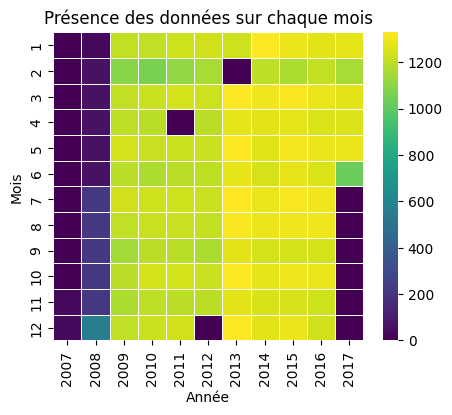

In [103]:
# Vérif val dispo par mois et par année

df_MM_AAAA = df.groupby(["MM", "AAAA"]).size().unstack(fill_value=0)

# Affichage graphe

plt.figure(figsize=(5, 4))
sns.heatmap(df_MM_AAAA, cmap="viridis", cbar=True, linewidths=0.5, linecolor="white")
plt.title("Présence des données sur chaque mois")
plt.xlabel("Année")
plt.ylabel("Mois")
plt.show()

## Valeurs extremes ou outliers
### Rainfall, Humidity : Valeurs extrêmes

### Rainfall
L'analyse des valeurs maximales ne souligne pas d'outliers, mais des valeurs extrêmes.
#Ex : CoffsHarbour a bien connue des plus torrentielles : https://www.abc.net.au/news/2009-11-08/flooded-coffs-region-declared-disaster-area/1133200

In [104]:
display(df.loc[df["Rainfall"] > 220])
print("Ce sont bien des valeurs extrêmes et non des outliers")

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,jour,MM,AAAA,District_Rainfall,Territory,Lat,Lon
9236,2009-11-07,CoffsHarbour,17.4,23.1,371.0,NaN,NaN,SW,S,13.0,19.0,93.0,81.0,1026.6,1025.9,8.0,5.0,18.6,22.0,Yes,1,5,11,2009,59,New South Wales,-30.298600,153.109412
73110,2009-01-12,Cairns,22.3,27.4,278.4,NW,59.0,SSE,NNW,17.0,11.0,96.0,98.0,1003.5,999.6,8.0,8.0,24.7,25.3,Yes,1,0,1,2009,31,Queensland,-16.920666,145.772185
73863,2011-02-04,Cairns,22.9,29.9,268.6,ENE,37.0,ENE,ENE,15.0,11.0,82.0,84.0,1011.1,1009.3,6.0,8.0,29.8,28.0,Yes,1,4,2,2011,31,Queensland,-16.920666,145.772185
75235,2015-02-08,Cairns,23.8,31.0,247.2,E,44.0,SSE,SE,17.0,28.0,100.0,74.0,1014.2,1011.4,8.0,8.0,25.3,30.0,Yes,1,6,2,2015,31,Queensland,-16.920666,145.772185
79100,2009-02-03,Townsville,22.8,25.4,236.8,ESE,48.0,ESE,SE,22.0,20.0,98.0,95.0,1003.8,1000.6,8.0,8.0,23.8,25.0,Yes,1,1,2,2009,32,Queensland,-19.256939,146.823954
121459,2011-02-16,Darwin,22.1,25.6,367.6,WSW,83.0,SSE,WSW,20.0,46.0,98.0,98.0,996.3,996.0,8.0,8.0,24.3,23.5,Yes,1,2,2,2011,14,Northern Territory,-12.460440,130.841047


Ce sont bien des valeurs extrêmes et non des outliers


### Humidity <3% Est-ce possible ?
A eu lieu l'été à Woomera et Alice Springs au climat assez désertique. ==> Ce sont des valeurs extrêmes pas des outliers.

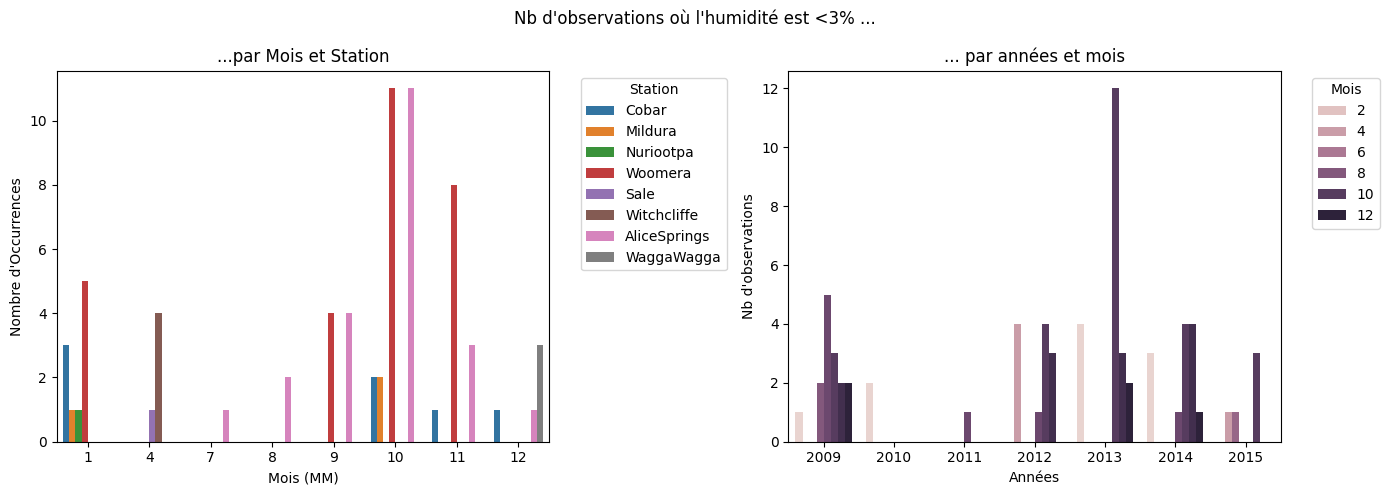

In [105]:
#Humidity <3% voir par station et par mois #ce serait mieux par Territory et saison
df_peu_humidite = df[(df['Humidity9am'] < 3) | (df['Humidity3pm'] < 3)]


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Nb d'observations où l'humidité est <3% ...")
# Subplot 1 : par Mois et Station
sns.countplot(x='MM', hue='Location', data=df_peu_humidite, ax=axes[0])
axes[0].set_title("...par Mois et Station")
axes[0].set_xlabel("Mois (MM)")
axes[0].set_ylabel("Nombre d'Occurrences")
axes[0].legend(title="Station", bbox_to_anchor=(1.05, 1), loc="upper left")

# Subplot 2 : par année
sns.countplot(x='AAAA', hue="MM", data=df_peu_humidite, ax=axes[1])
axes[1].set_title("... par années et mois")
axes[1].set_xlabel("Années")
axes[1].set_ylabel("Nb d'observations")
axes[1].legend(title="Mois", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout();

## Min max temp 


Site BOM 
###### "Air temperature is measured in a shaded enclosure (most often a Stevenson Screen) at a height of approximately 1.2 m above the ground. Maximum and minimum temperatures for the previous 24 hours are nominally recorded at 9 am local clock time. Minimum temperature is recorded against the day of observation, and the maximum temperature against the previous day. If, for some reason, an observation is unable to be made, the next observation is recorded as an accumulation. Accumulated data can affect statistics such as the Date of the Highest Temperature, since the exact date of occurrence is unknown .
http://www.bom.gov.au/climate/cdo/about/definitionstemp.shtml


###### Min	Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.	Max	Maximum temperature in the 24 hoursfrom 9am. Sometimes only known to the nearest whole degree.
http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

### Mode de fonctionnement
Si on est Mercredi 
> Min = round(Min(Mardi9am,Mardi3pm,Mercredi9am),0)

> Max = round(Max(Mercredi9am, Mercredi3pm, Jeudi9am),0)
puisque Max(Mardi9am,Mardi3pm,Mercredi9am) sera enregistré sur Mardi ("against previous day")

Nous allons :
1 Création de features qui correspondent au mode de calcul du BOM, pour s'assurer que l'on arrive à calculer MinTemp et MaxTemp
2 Explorer d'autres alternatives plus simple à mettre en oeuvre que d'aller chercher la veille ou le lendemain si l'observation à des NaN, ou si j'ai supprimé ces observations.

In [106]:
df_check_temp= df[["Date","Location","MinTemp","MaxTemp","Temp9am", "Temp3pm"]]
df_check_temp.reset_index

#Comme il y a des trous, si l'observation précédente n'est pas la veille(ou le lendemain), prendre celle du jour
# --- Pour Temp3pm_veille ---
# On récupère la date et la valeur décalée
df_check_temp["Date_veille"] = df_check_temp.groupby("Location")["Date"].shift(1)
df_check_temp["Temp3pm_veille_shift"] = df_check_temp.groupby("Location")["Temp3pm"].shift(1)
# Si la différence de jours est exactement 1, on garde la valeur décalée, sinon on ne met rien
df_check_temp["Temp3pm_veille"] = np.where(
    (df_check_temp["Date"] - df_check_temp["Date_veille"]).dt.days == 1,
    df_check_temp["Temp3pm_veille_shift"], np.nan)

# --- Pour Temp9am_veille ---
df_check_temp["Temp9am_veille_shift"] = df_check_temp.groupby("Location")["Temp9am"].shift(1)
df_check_temp["Temp9am_veille"] = np.where(
    (df_check_temp["Date"] - df_check_temp["Date_veille"]).dt.days == 1,
    df_check_temp["Temp9am_veille_shift"], np.nan)

# --- Pour Temp9am_lendemain ---
df_check_temp["Date_lendemain"] = df_check_temp.groupby("Location")["Date"].shift(-1)
df_check_temp["Temp9am_lendemain_shift"] = df_check_temp.groupby("Location")["Temp9am"].shift(-1)
df_check_temp["Temp9am_lendemain"] = np.where(
    ((df_check_temp["Date_lendemain"] - df_check_temp["Date"]).dt.days) == 1,
    df_check_temp["Temp9am_lendemain_shift"],np.nan)


# Suppression des colonnes auxiliaires
df_check_temp.drop(columns=["Date_veille", "Temp3pm_veille_shift", "Temp9am_veille_shift", "Date_lendemain", "Temp9am_lendemain_shift"], inplace=True)

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\144716526.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\144716526.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\144716526.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [107]:
# Min
df_check_temp["Min_BOM_9V3V9J"] = df_check_temp[["Temp9am_veille", "Temp3pm_veille", "Temp9am"]].min(axis=1).round(0) #Meilleur résultat
# Temp9am du jour : 2e meilleur résultat


#Max Temp
df_check_temp["Max_BOM_9J3J9D"] = df_check_temp[["Temp9am","Temp3pm","Temp9am_lendemain"]].max(axis=1).round(0)#Meilleure corrélation

#Dans une optique de complétion des NaN avant train_test_split 
# (donc en utilisant les données de la ligne pour éviter le dataleakage en allant piocher sur les données de la veille:du jour")
df_check_temp["Max9J3J"] = df_check_temp[["Temp9am","Temp3pm"]].max(axis=1).round(0)#2 et 3Temp3pm

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\1253632935.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\1253632935.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Amélie\AppData\Local\Temp\ipykernel_18456\1253632935.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

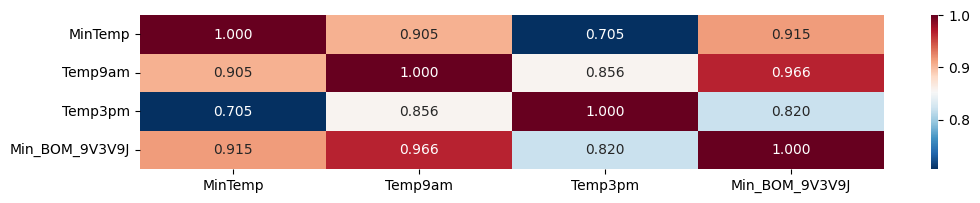

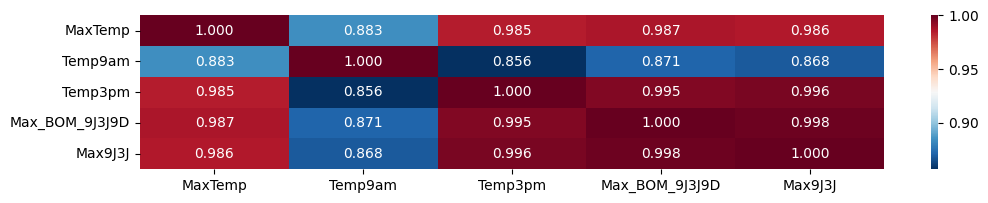

In [108]:
plt.figure(figsize=(12,2))
df_check_temp_corr_min= df_check_temp[['MinTemp', 'Temp9am', 'Temp3pm', 'Min_BOM_9V3V9J']]
sns.heatmap(df_check_temp_corr_min.corr(),annot=True,cmap="RdBu_r",fmt= ".3f");

plt.figure(figsize=(12,2))
df_check_temp_corr_max= df_check_temp[['MaxTemp', 'Temp9am', 'Temp3pm', 'Max_BOM_9J3J9D', 'Max9J3J']]   
sns.heatmap(df_check_temp_corr_max.corr(),annot=True,cmap="RdBu_r",fmt= ".3f");

### Préco de remplissage 
> MinTemp

Pour éviter la fuite de données, on va éviter d'utiliser la veille et le lendemain: 
df["MinTemp"]=df["MinTemp"].fillna(df["Temp9am"].round(0)) #2e meilleure corrélation à 0.905. Même avec la définition du BOM, la corrélation n'est que à 0.915 ce qui est normal Le le min vient la nuit, donc MinTemp de température à 9am et 3pm surrestime forcément MinTemp
S'il y a peu de NaN, le mieux serait sans doute un KNN Imputer

> MaxTemp
Temperature la plus chaude du jour de l'observation (parmi 9am et 3pm), arrondi à l'entier.

> 9am
On pourrait prendre le minimum de la nuit, car il est très corrélé. Mais cela sous-estimera la valeur "réelle" de 9am. S'il y a peu de NaN, le mieux serait sans doute un KNN Imputer

> 3pm : Temperature maximale du jour

In [109]:
print("Nb de NaN sur TempMin si on voulait faire un KNN Imputer ",df["MinTemp"].isna().sum())
print("Nb de NaN sur Temp9am si on voulait faire un KNN Imputer ",df["Temp9am"].isna().sum())

Nb de NaN sur TempMin si on voulait faire un KNN Imputer  227
Nb de NaN sur Temp9am si on voulait faire un KNN Imputer  309


### Remplissage NaN "autorisé"

In [110]:
# Créations de colonnes temporaire pour aider à la complétion
df["WarmerTemp"] = df[["Temp9am", "Temp3pm"]].max(axis=1)
df["StrongestWind"] = df[["WindSpeed9am", "WindSpeed3pm"]].max(axis=1)

Colonnes non prises Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'District_Rainfall', 'Territory'], dtype='object')


<Axes: >

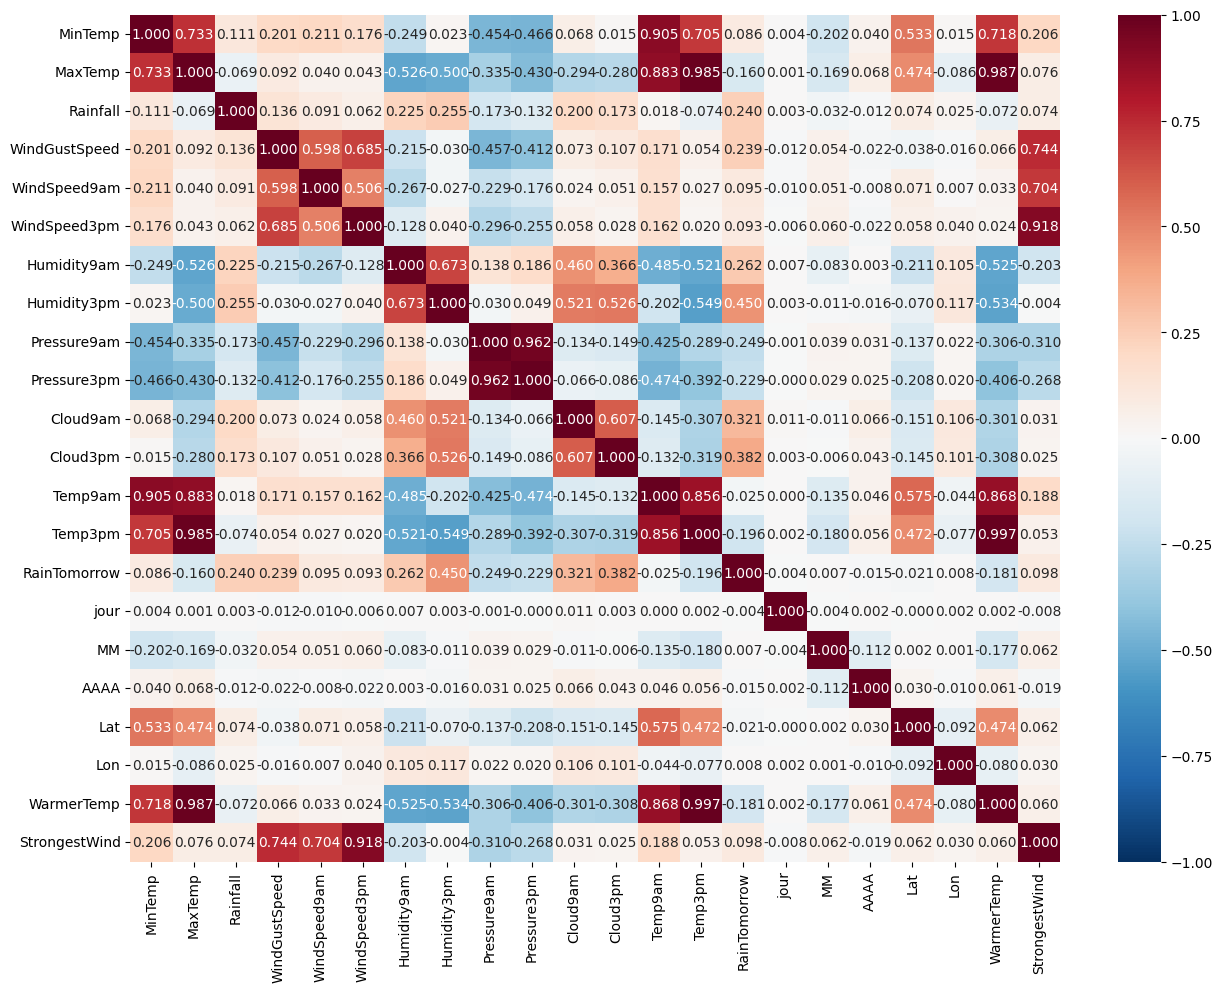

In [111]:
#Corrélation : 
dataframe_correlation=df
print("Colonnes non prises",dataframe_correlation.select_dtypes(exclude = ['int', 'float']).columns)
dataframe_correlation=dataframe_correlation.select_dtypes(include = ['int', 'float'])


#Corrélation de Pearson entre les variables explicatives quantitatives présentées sous forme de Heatmap
plt.figure(figsize=(15, 11))  # Optional: Adjust figure size
sns.heatmap(dataframe_correlation.corr(),annot=True,cmap="RdBu_r",fmt= ".3f", center = 0, vmin=-1, vmax=1) 

In [112]:
#Traiter les NAN de MaxTemp, Temp3pm, Pressure9am, Pressure3pm où corrélation >0.96
df["MaxTemp"]=df["MaxTemp"].fillna(df["WarmerTemp"].round(0)) #arrondi à l'entier comme la definition du BOM
df = df.drop(["WarmerTemp"],axis=1)

df["Temp3pm"]=df["Temp3pm"].fillna(df["MaxTemp"])

df["Pressure3pm"]=df["Pressure3pm"].fillna(df["Pressure9am"])
df["Pressure9am"]=df["Pressure9am"].fillna(df["Pressure3pm"])

#Wind gust 
Speed of strongest wind gust in the 24 hours to midnight	kilometres per hour
Maximum wind gust recorded for each calendar month and the year, over the period of record. A gust is any sudden increase of wind speed of short duration; typically a 3 second time period is used. The maximum wind gust for a day is measured from midnight to midnight. If, for some reason, an observation is unable to be made, the next observation is recorded as an accumulation. Accumulated data can affect the Date of the Maximum Wind Gust, since the exact date of occurrence is unknown.

-> Corrélation de 0.74 avec la variable StrongestWind -> c'est pas top. On laissera faire le KNNImputer.

In [113]:
df = df.drop(["StrongestWind"],axis=1)

### Encodage "stateless"

In [114]:
#Encodage cyclique du mois 
def encode_month(df, month_col="MM"):
    """Encode le mois en sin et cos puis supprime la colonne originale."""
    df['month_sin'] = np.sin(2 * np.pi * (df[month_col] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df[month_col] - 1) / 12)
    df=df.drop(columns=[month_col],axis=1)
    return df

df = encode_month(df, "MM")

Les directions du vent sont cycliques (cf. cercle de la rose des vents) : un encodage cyclique est donc possible

In [115]:
from sklearn.preprocessing import FunctionTransformer

# Traitement des NaN dans la direction du vent
# Liste ordonnée des 16 directions du vent
directions = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
# Créer un dictionnaire qui mappe chaque direction à un angle en radians
angle_mapping = {dir: (i * 2 * np.pi / 16) for i, dir in enumerate(directions)}
#angle_mapping["ZZZ"] = np.nan  # Pas de vent => NaN


# Encodage trigonométrique avec FunctionTransformer

# Convertir les directions en angles
def wind_direction_to_angle(df, column):
    df[f'{column}_angle'] = df[column].map(angle_mapping)
    return df

for colonne in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df = wind_direction_to_angle(df, colonne)

# Définition des transformers
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Appliquer la transformation trigonométrique
period = 2 * np.pi  # Période complète du cercle

for colonne in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[f'{colonne}_sin'] = sin_transformer(period).fit_transform(df[[f'{colonne}_angle']])
    df[f'{colonne}_cos'] = cos_transformer(period).fit_transform(df[[f'{colonne}_angle']])
    
#Supprimer les colonnes 
df=df.drop(columns=['WindGustDir_angle', 'WindDir9am_angle', 'WindDir3pm_angle','WindGustDir', 'WindDir9am', 'WindDir3pm'],axis=1)


Vérification de la distribution de la variable cible? 

In [116]:
# #Est-ce que l'on a impacté sa distribution avec les suppressions d'observations?
repartition_var_cible_apres = df["RainTomorrow"].value_counts(normalize=True, dropna=False)
display("a present",repartition_var_cible_apres)

display("avant",repartition_var_cible_avant)

'a present'

RainTomorrow
0    0.777866
1    0.222134
Name: proportion, dtype: float64

'avant'

RainTomorrow
No     0.758394
Yes    0.219146
NaN    0.022460
Name: proportion, dtype: float64

### Suppressions de features

In [117]:
#Suppresion de RainToday qui est calculé sur Rainfall et qui entraînera une colinéarité
#Si au sein de la base il existe des variables qui ont été construites a posteriori, autrement dit après avoir obtenu l'information, 
# alors ces variables ne peuvent pas faire partie des variables explicatives du modèle prédictif. 
df = df.drop("RainToday", axis = 1)

ou dropper Rainfall?

In [118]:
#Dropper les features ajouter pour faciliter l EDA
df = df.drop(["District_Rainfall","jour","Territory"], axis = 1)

In [119]:
#Récap des suppressions
nom_colonne_actuel = df.columns
print("Colonnes ajoutées :",[col for col in nom_colonne_actuel if col not in nom_colonne_initial])
print("Colonnes enlevées :",[col for col in nom_colonne_initial if col not in nom_colonne_actuel])


nom_station_actuel = list(set(df["Location"]))
print("Stations enlevées :",[station for station in nom_station_initial if station not in nom_station_actuel])

Colonnes ajoutées : ['AAAA', 'Lat', 'Lon', 'month_sin', 'month_cos', 'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos']
Colonnes enlevées : ['Evaporation', 'Sunshine', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Stations enlevées : ['MountGinini', 'Penrith', 'Newcastle', 'Williamtown', 'Melbourne', 'SalmonGums']


## Objectif etre OK avec Florent jusqu'à cette étape

In [120]:
df.to_csv("df_abo_step1.csv", index = False)